## 1.0 Imports

In [2]:
import math
import datetime
import pickle
import random
import json
import requests
import inflection
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb

from skopt                 import dummy_minimize, gp_minimize
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats as ss
from dython.nominal        import associations 
from boruta                import BorutaPy
from tabulate              import tabulate

from sklearn                 import metrics as mt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder

### Helper Functions

In [2]:
def jupyter_settings():
   
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

# ML models performance
def ml_error(model_name, y, y_hat):
    mae = mt.mean_absolute_error(y, y_hat)
    mape = mt.mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mt.mean_squared_error(y, y_hat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# Cross Validation
def cross_val( x_traning, k_fold, model_name, model, verbose=False):
    
    tscv = TimeSeriesSplit(n_splits=k_fold)

    xx = x_traning.copy()
    xx.set_index('date', inplace=True)
    xx.sort_index(inplace=True)
    xx_ = xx.drop('sales', axis=1)
    yy_ = xx['sales']  
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for train_index, test_index in tscv.split(xx_):
        X_train, X_test = xx_.iloc[train_index, :], xx_.iloc[test_index, :]
        y_train, y_test = yy_.iloc[train_index], yy_.iloc[test_index]
        

        # model
        m = model.fit( X_train, y_train )

        # prediction
        yhat = m.predict( X_test )

        # performance
        m_result = ml_error( model_name, np.expm1(y_test), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
       
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list),2).astype(str) + ' +\- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE': np.round(np.mean(mape_list),2).astype(str) + ' +\- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE': np.round(np.mean(rmse_list),2).astype(str) + ' +\- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

### Loading Data

In [3]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='inner', on='Store')

## 2.0 Data Descripition

In [5]:
df1 = df_raw.copy()

### Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new

### Data Dimensions

In [7]:
# Rows and Columns
df1.shape

(1017209, 18)

### Data Types

In [8]:
# Data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NA

In [12]:
# Convert date type
df1['date'] = pd.to_datetime( df1['date'] )

#competition_distance       
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan( x ) else x
)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(
                                             lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1
                                             )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
                                             lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1
                                             )
#promo2_since_week 
df1['promo2_since_week'] = df1.apply( 
                                    lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1
                                             )
#promo2_since_week 
df1['promo2_since_week'] = df1.apply( 
                                    lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1
                                             )
#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)
map_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map( map_month )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### Change astype

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

### Descriptive Statistical

In [14]:
# Split numerical and categorical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [15]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion - std, min, max, range, skew, kurtosis
ds1 = pd.DataFrame(num_attributes.apply(np.std))
ds2 = pd.DataFrame(num_attributes.apply(min))
ds3 = pd.DataFrame(num_attributes.apply(max))
ds4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
ds5 = pd.DataFrame(num_attributes.skew())
ds6 = pd.DataFrame(num_attributes.kurtosis())

In [16]:
statistic = pd.concat([ct1, ct2, ds1, ds2, ds3, ds4, ds5, ds6], axis=1)
statistic.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [17]:
statistic

,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

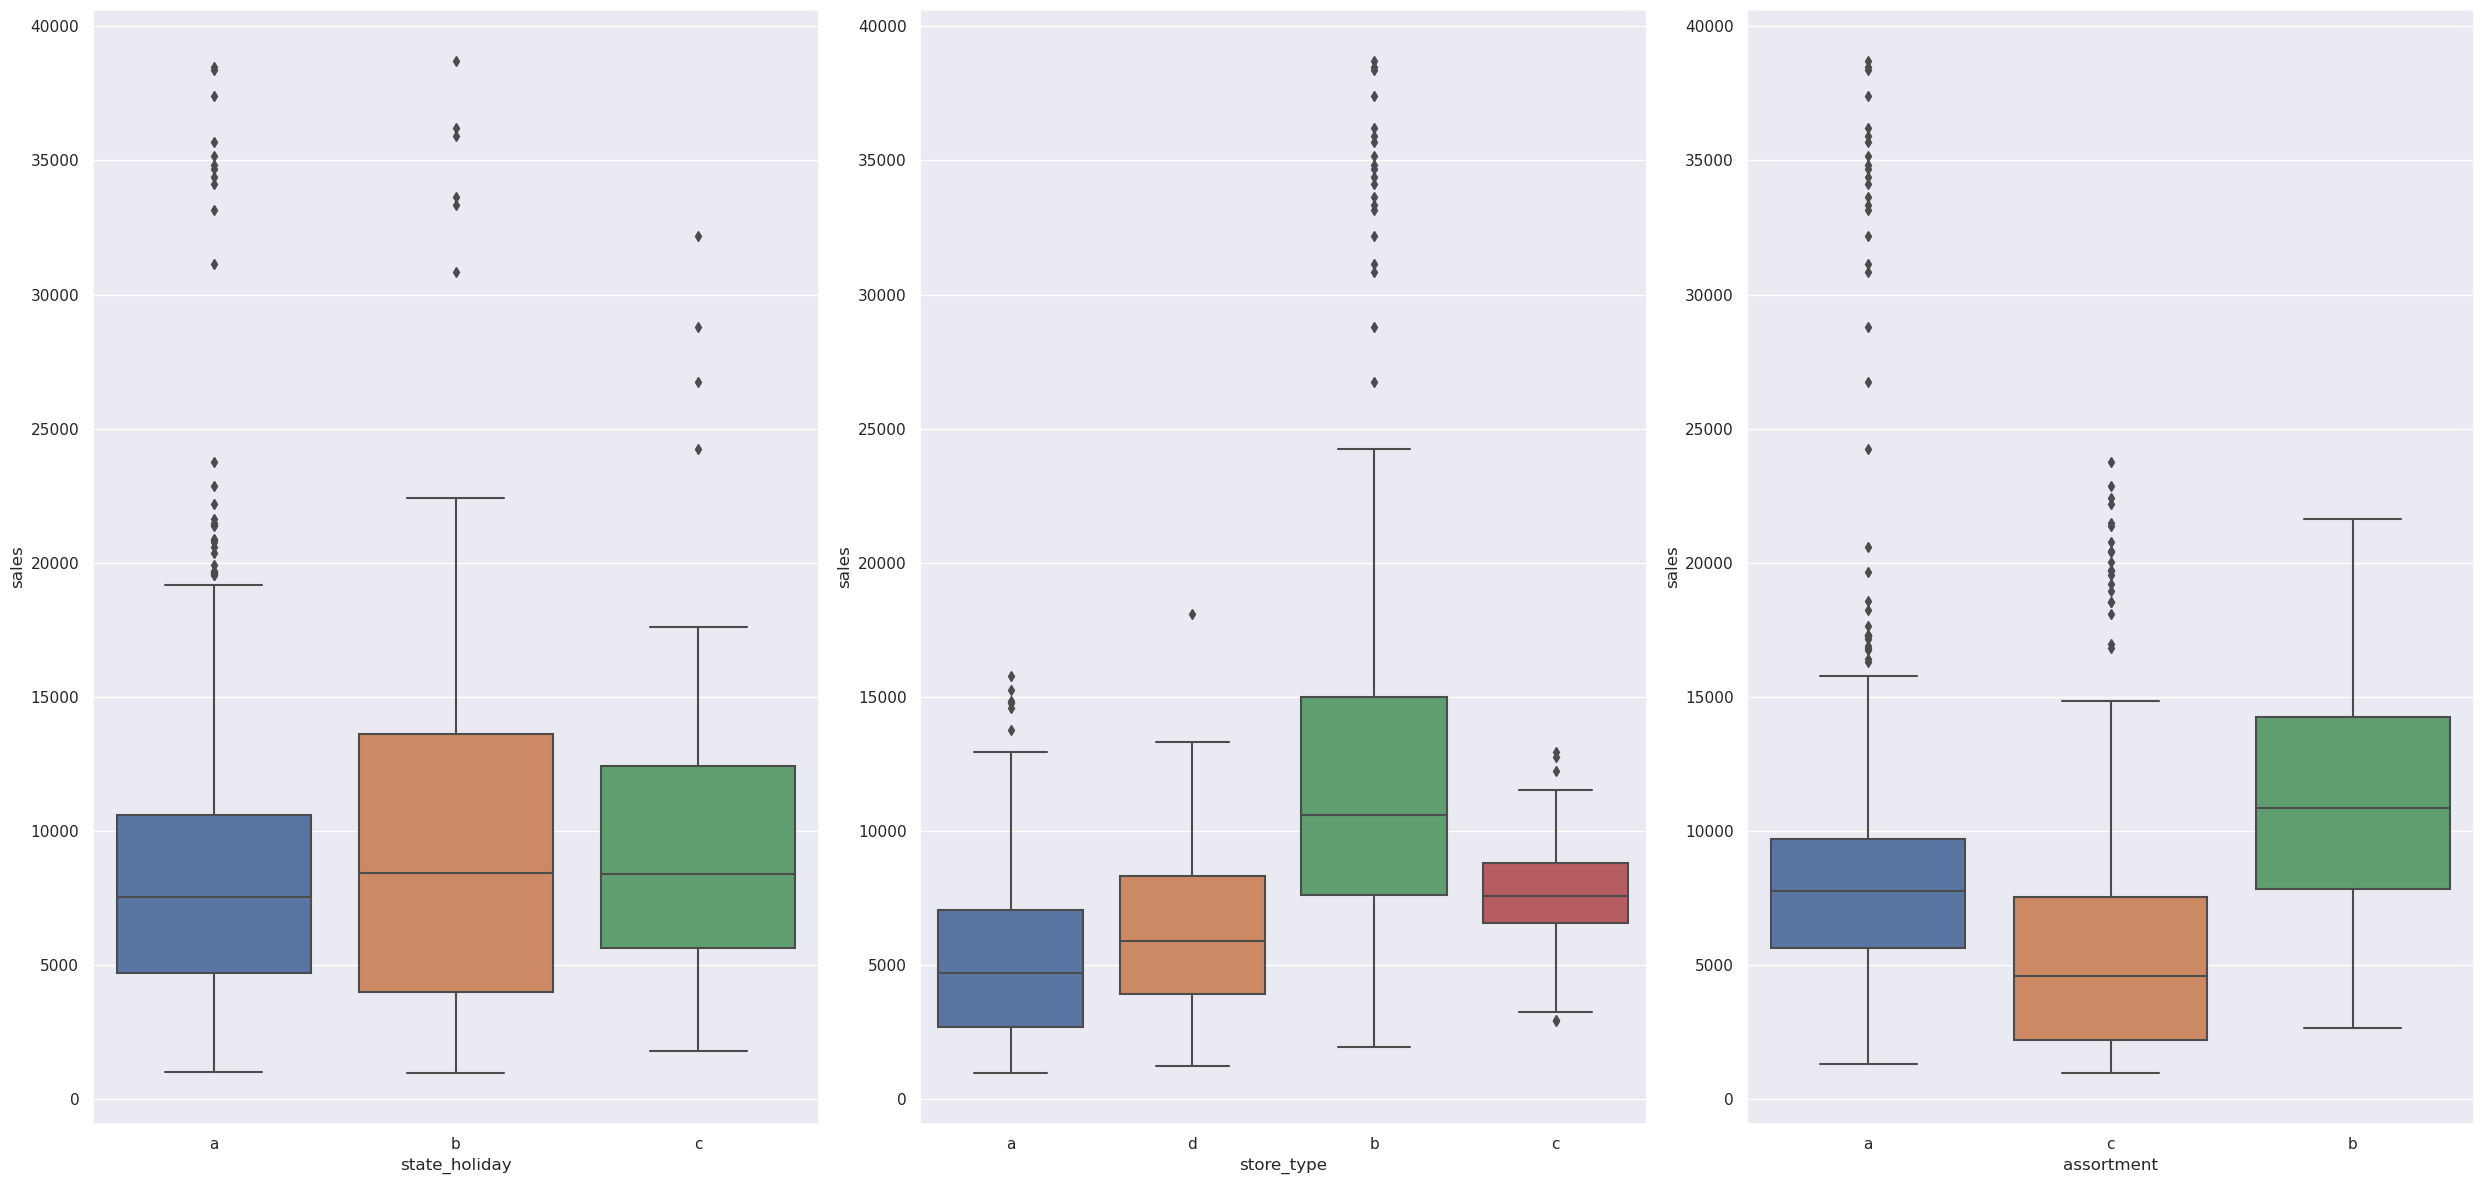

In [19]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']> 0)]

plt.subplot( 1, 3, 1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1)
plt.subplot( 1, 3, 2)
sns.boxplot(x= 'store_type', y='sales', data=aux1)
plt.subplot( 1, 3, 3)
sns.boxplot(x= 'assortment', y='sales', data=aux1)
plt.tight_layout()

<Axes: xlabel='assortment', ylabel='sales'>

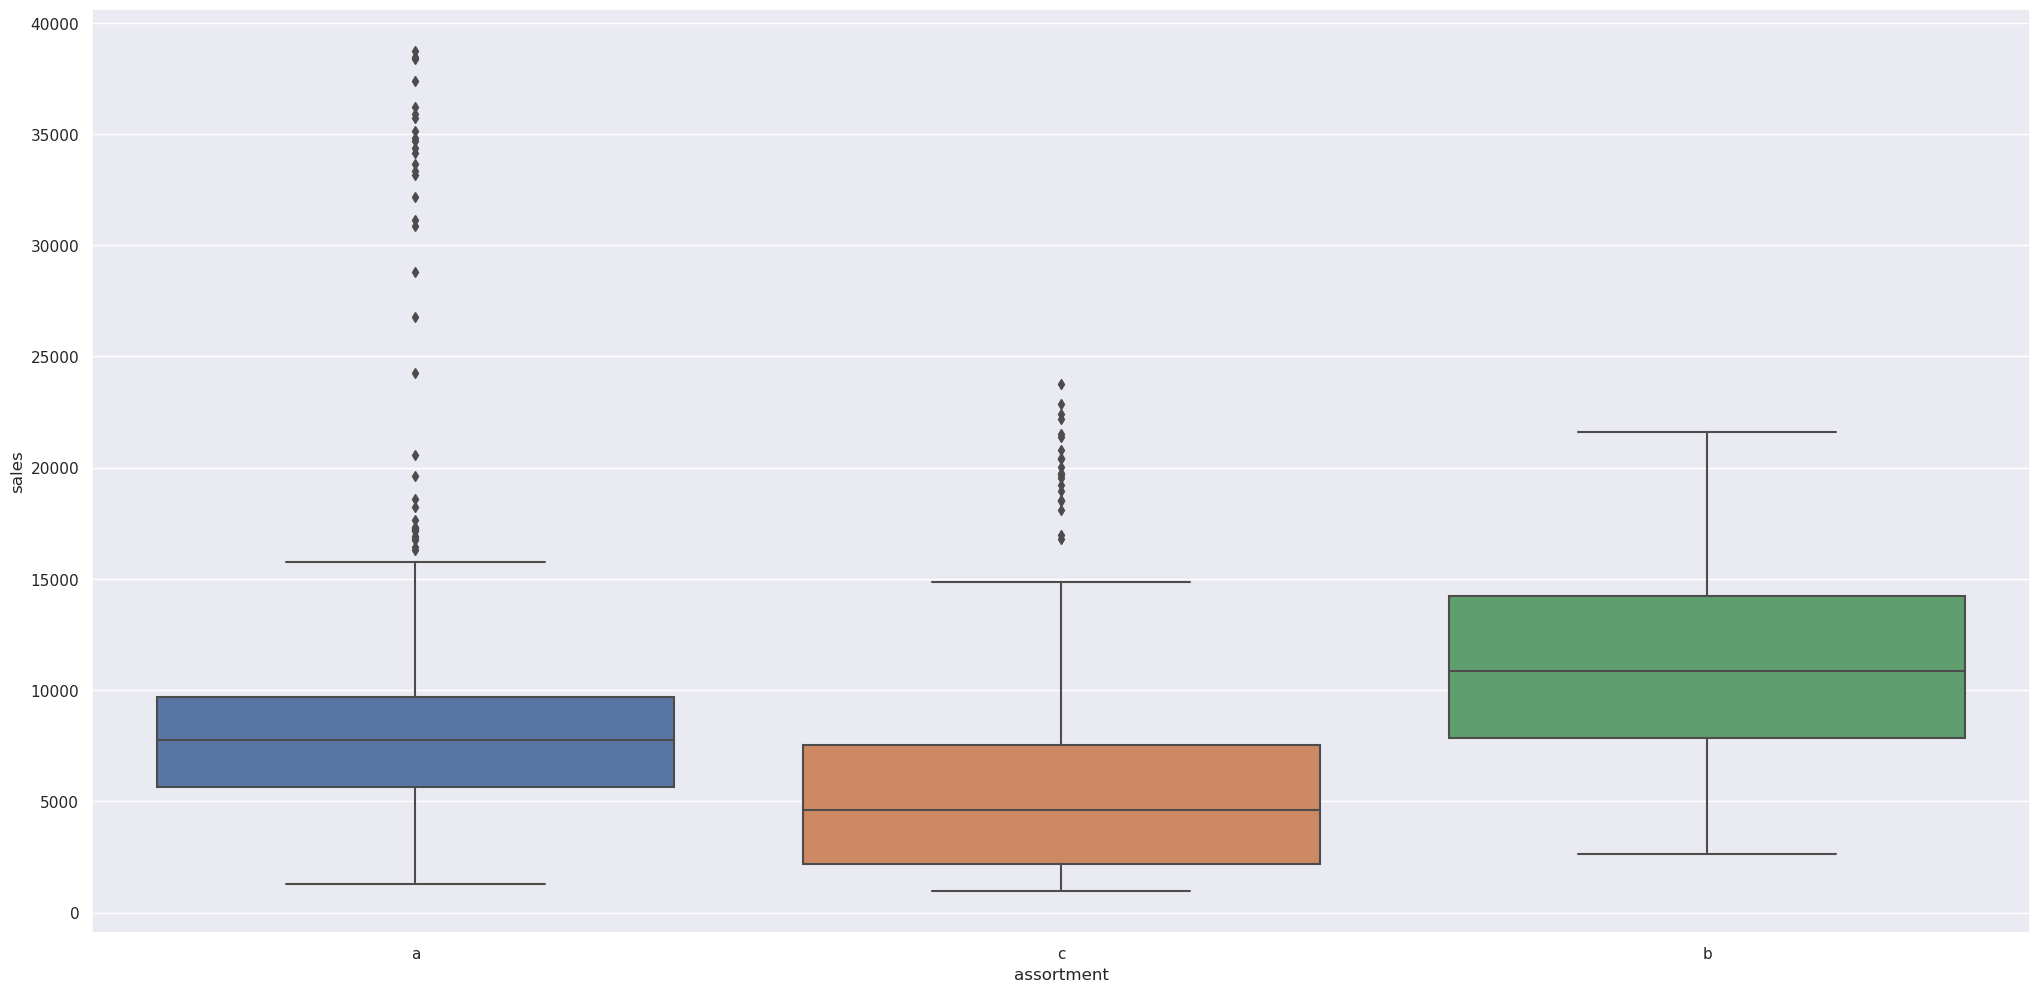

In [20]:
sns.boxplot(x= 'assortment', y='sales', data=aux1)

## 3.0 Feature engineering

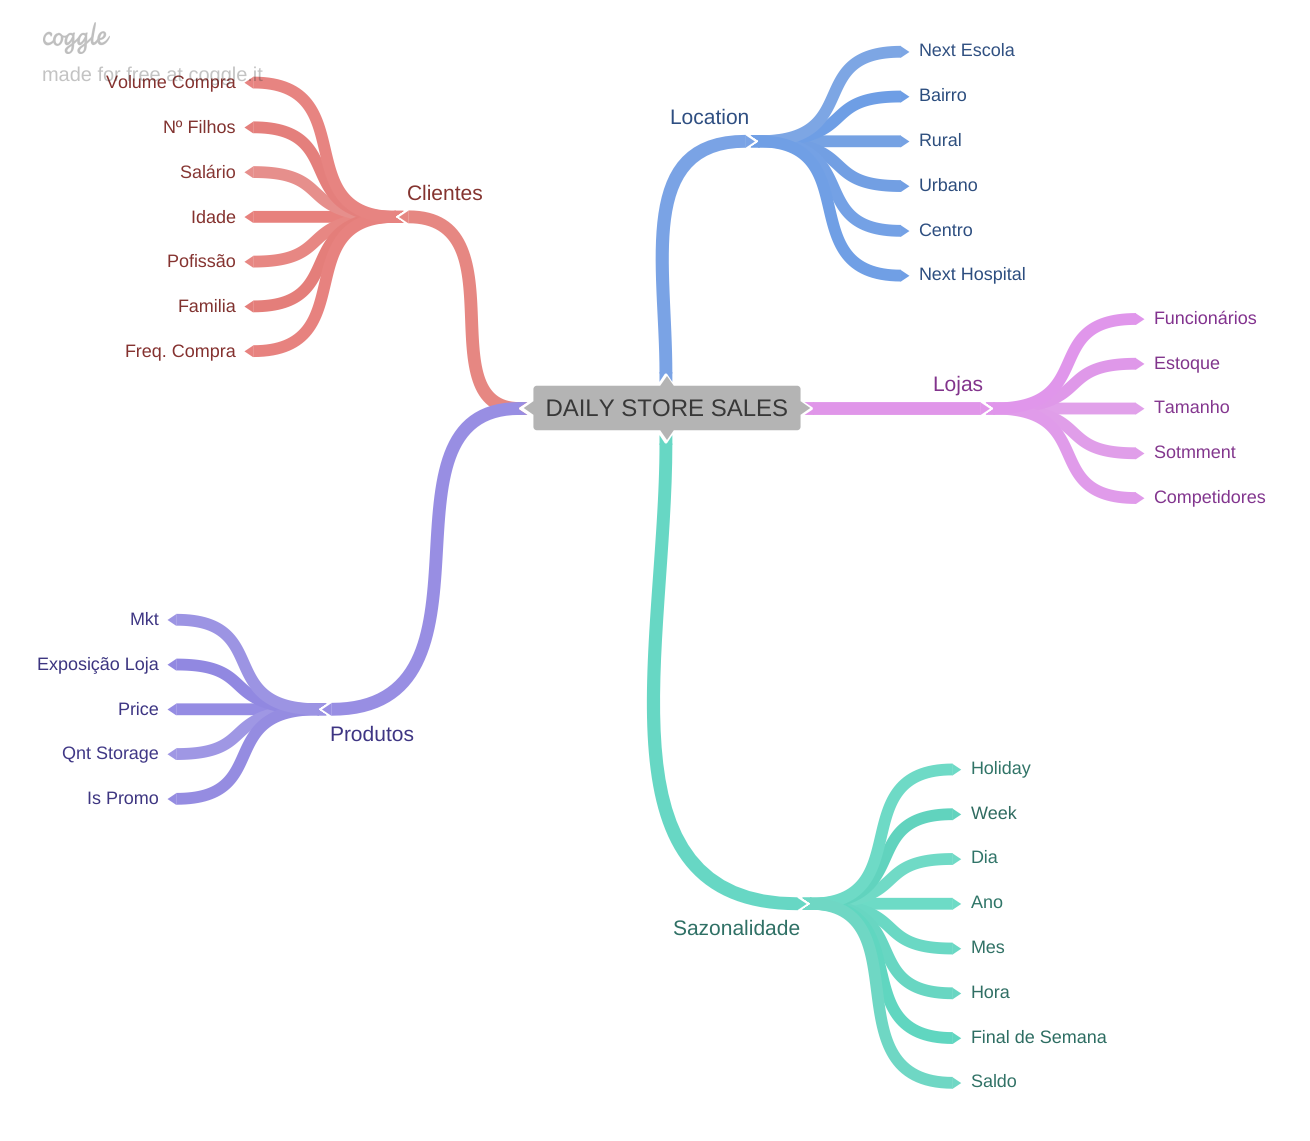

In [21]:
img_path = 'img/mind_map_hipotesis.png'
Image(img_path)

### Hypothesis Creation

In [22]:
# Final hypothesis
#1. Lojas com maior sortimentos deveriam vender mais.
#2. Lojas com competidores mais próximos deveriam vender menos.
#3. Lojas com competidores à mais tempo deveriam vendem mais.
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#5. Lojas com mais dias de promoção deveriam vender mais.
#7. Lojas com mais promoções consecutivas deveriam vender mais.
#8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#9. Lojas deveriam vender mais ao longo dos anos.
#10. Lojas deveriam vender mais no segundo semestre do ano.
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#12. Lojas deveriam vender menos aos finais de semana.
#13. Lojas deveriam vender menos durante os feriados escolares.


### Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


## 4.0 Filtragem de variáveis

In [25]:
df3 = df2.copy()

In [26]:
# Filter rows
df3 = df3[(df3['sales'] > 0) & (df3['open'] != 0)]

In [27]:
# Filter columns
drop_cols = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(drop_cols, axis=1)

## 5.0 Exploratory Data Analysis

In [28]:
df4 = df3.copy()

In [29]:
# Final hypothesis
#1. Lojas com maior sortimentos deveriam vender mais.
#2. Lojas com competidores mais próximos deveriam vender menos.
#3. Lojas com competidores à mais tempo deveriam vendem mais.
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#5. Lojas com mais dias de promoção deveriam vender mais.
#6. Lojas com mais promoções consecutivas deveriam vender mais.
#7. Lojas abertas durante o feriado de Natal deveriam vender mais.
#8. Lojas deveriam vender mais ao longo dos anos.
#9. Lojas deveriam vender mais no segundo semestre do ano.
#10. Lojas deveriam vender mais depois do dia 10 de cada mês.
#11. Lojas deveriam vender menos aos finais de semana.
#12. Lojas deveriam vender menos durante os feriados escolares.

### Univariate Analysis

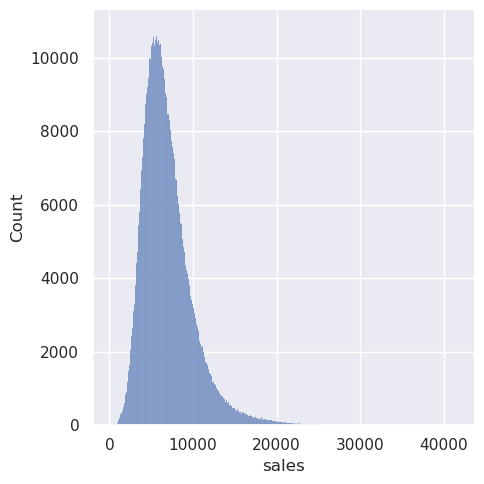

In [30]:
# Reponse Variable
sns.displot(df4['sales']);

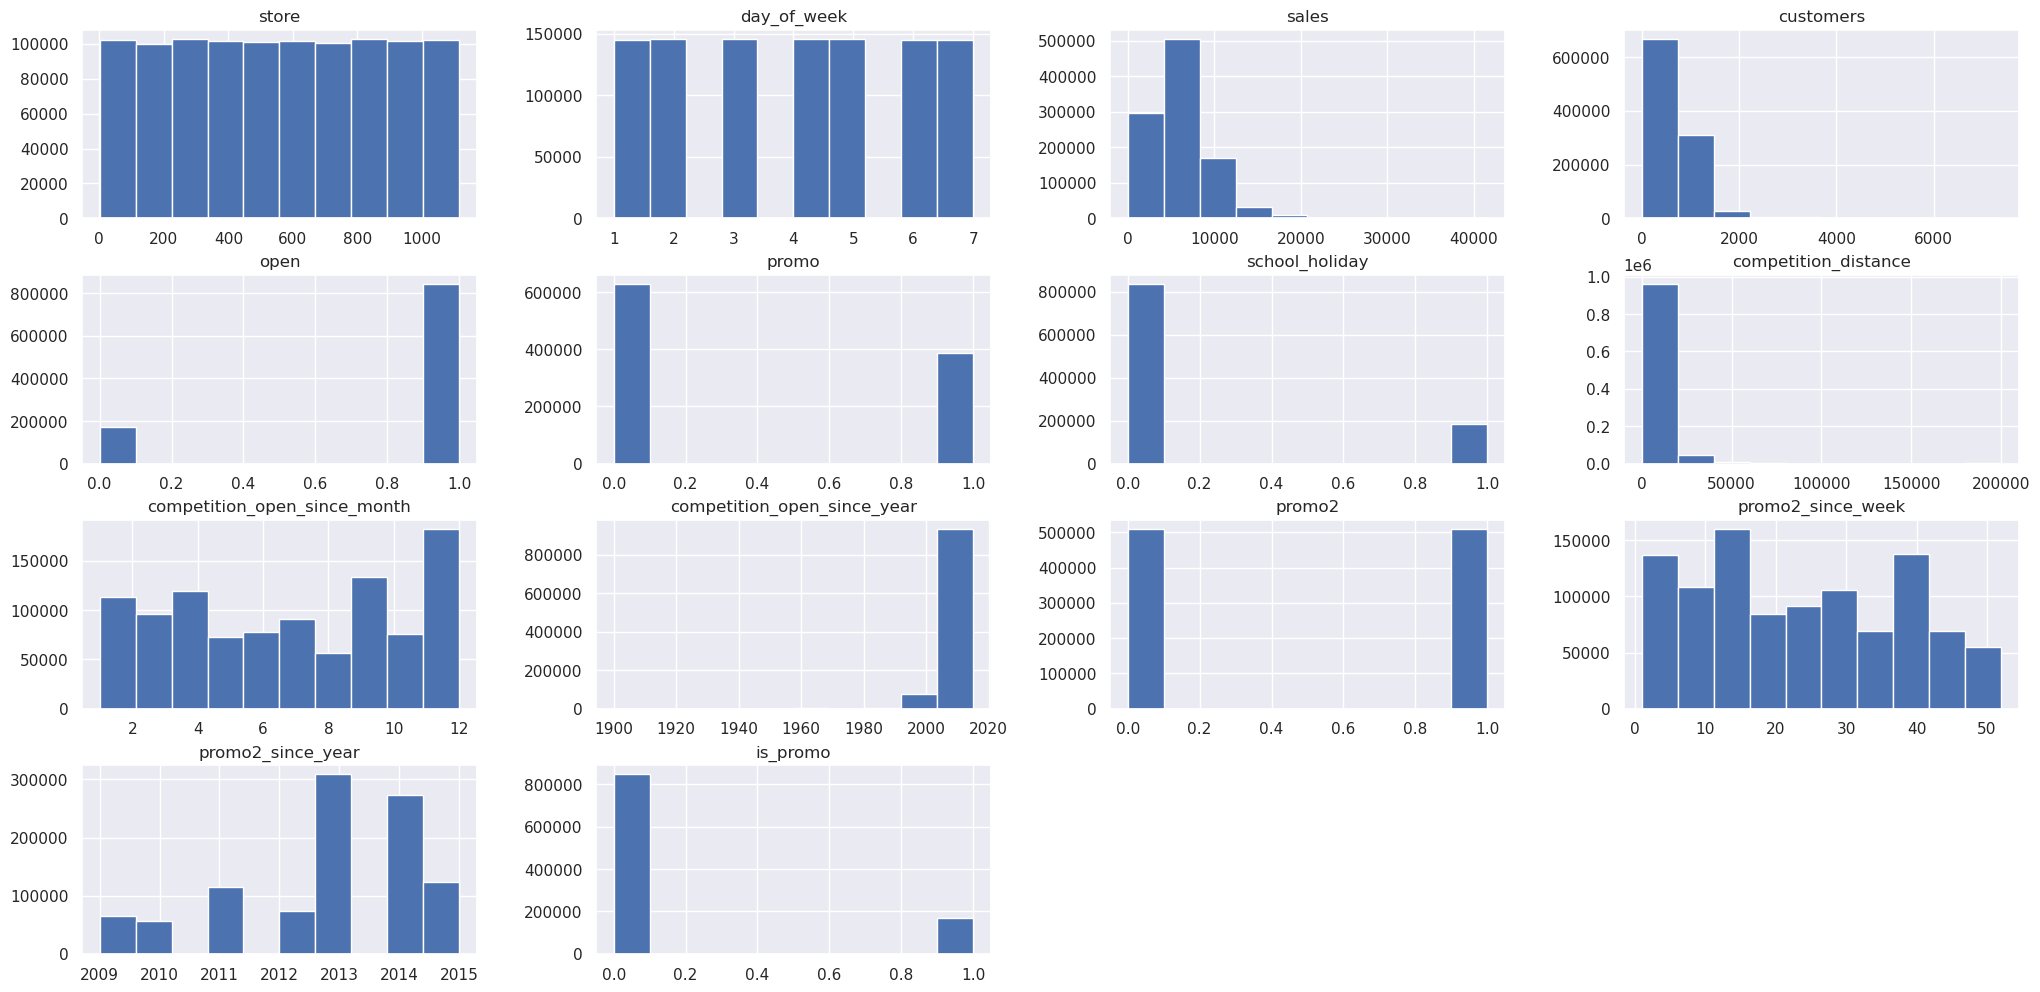

In [31]:
# Numerical Variables
num_attributes.hist();

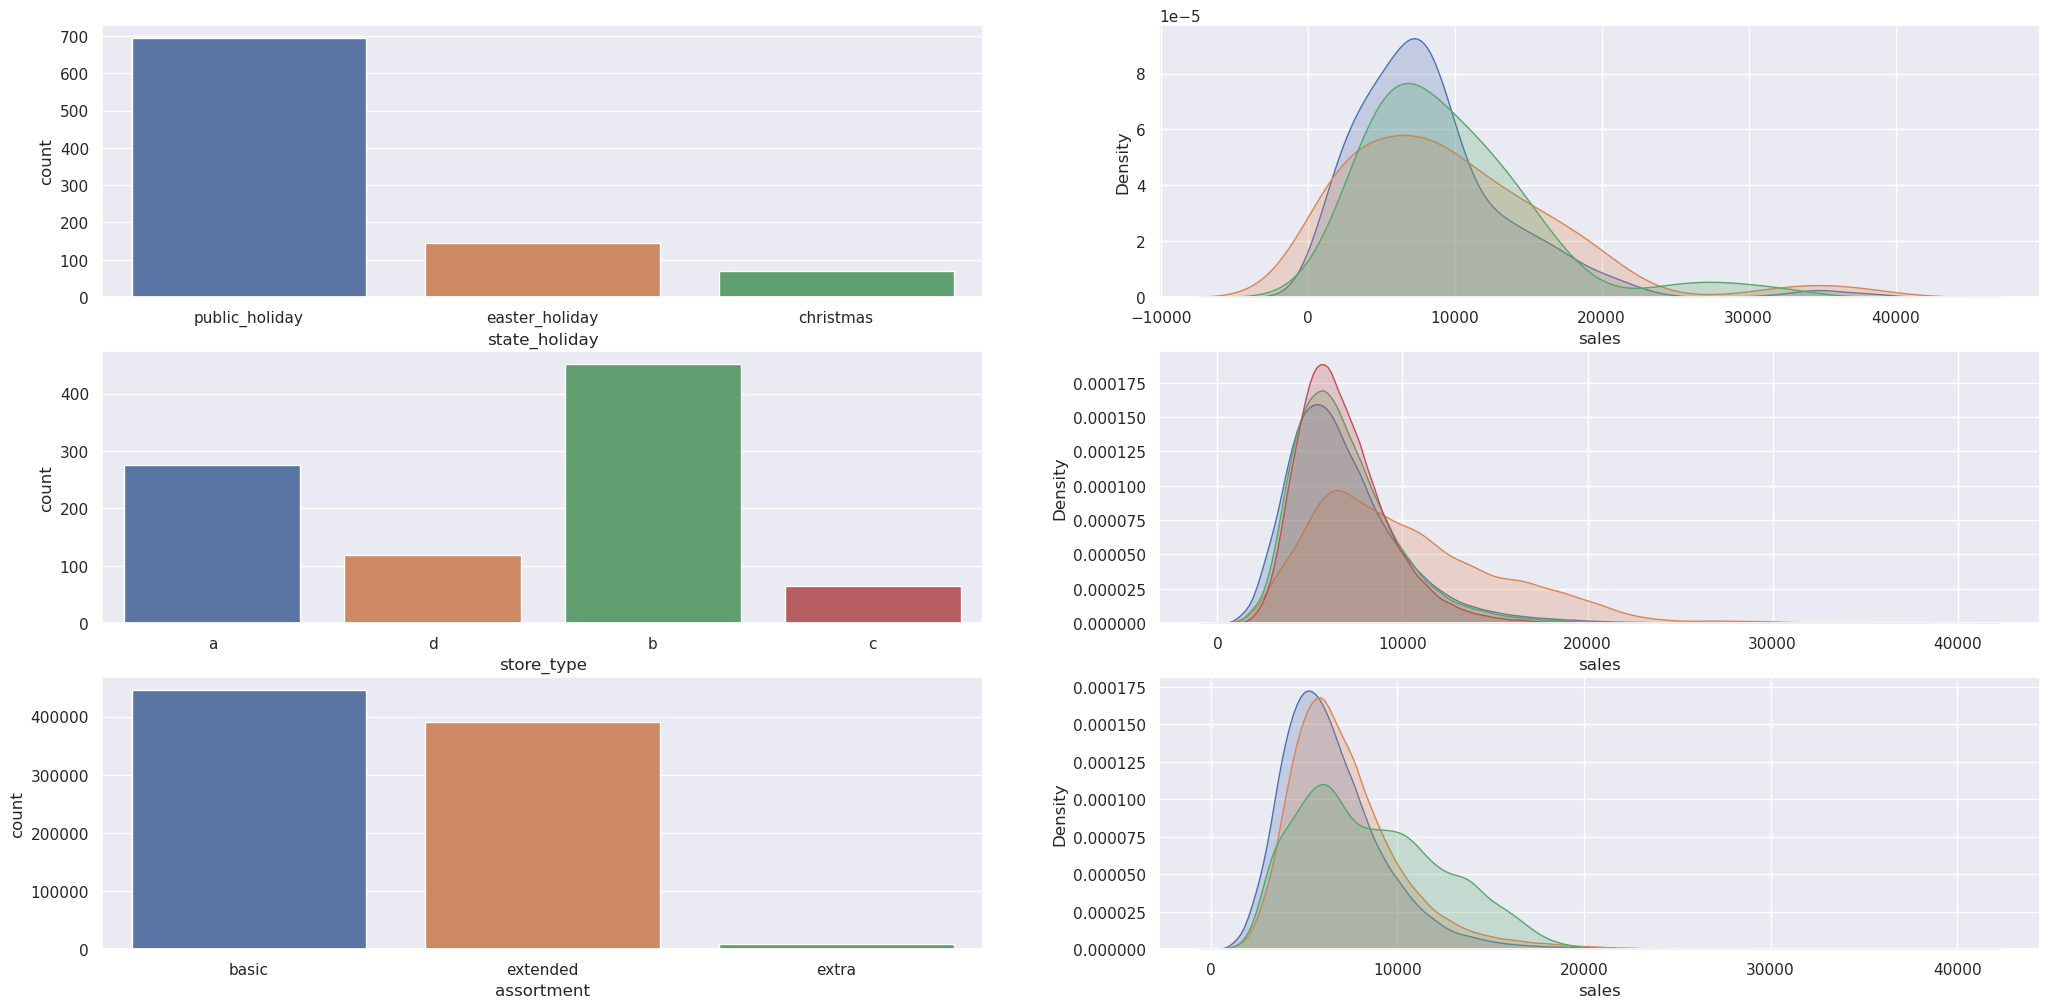

In [32]:
# State Holiday
aux1 = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(x=aux1['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True, legend=False);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, legend=False);
#sns.kdeplot(df4[df4['state_holiday'] == 'regular_day']['sales'], label='public_holiday', fill=True);


# Store type
plt.subplot(3,2,3)
sns.countplot(x=aux1['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], fill=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], fill=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], fill=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], fill=True);

# Assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], fill=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], fill=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], fill=True);


### Bivariant Analysis

### 1. Lojas com maior sortimentos deveriam vender mais.
#### TRUE

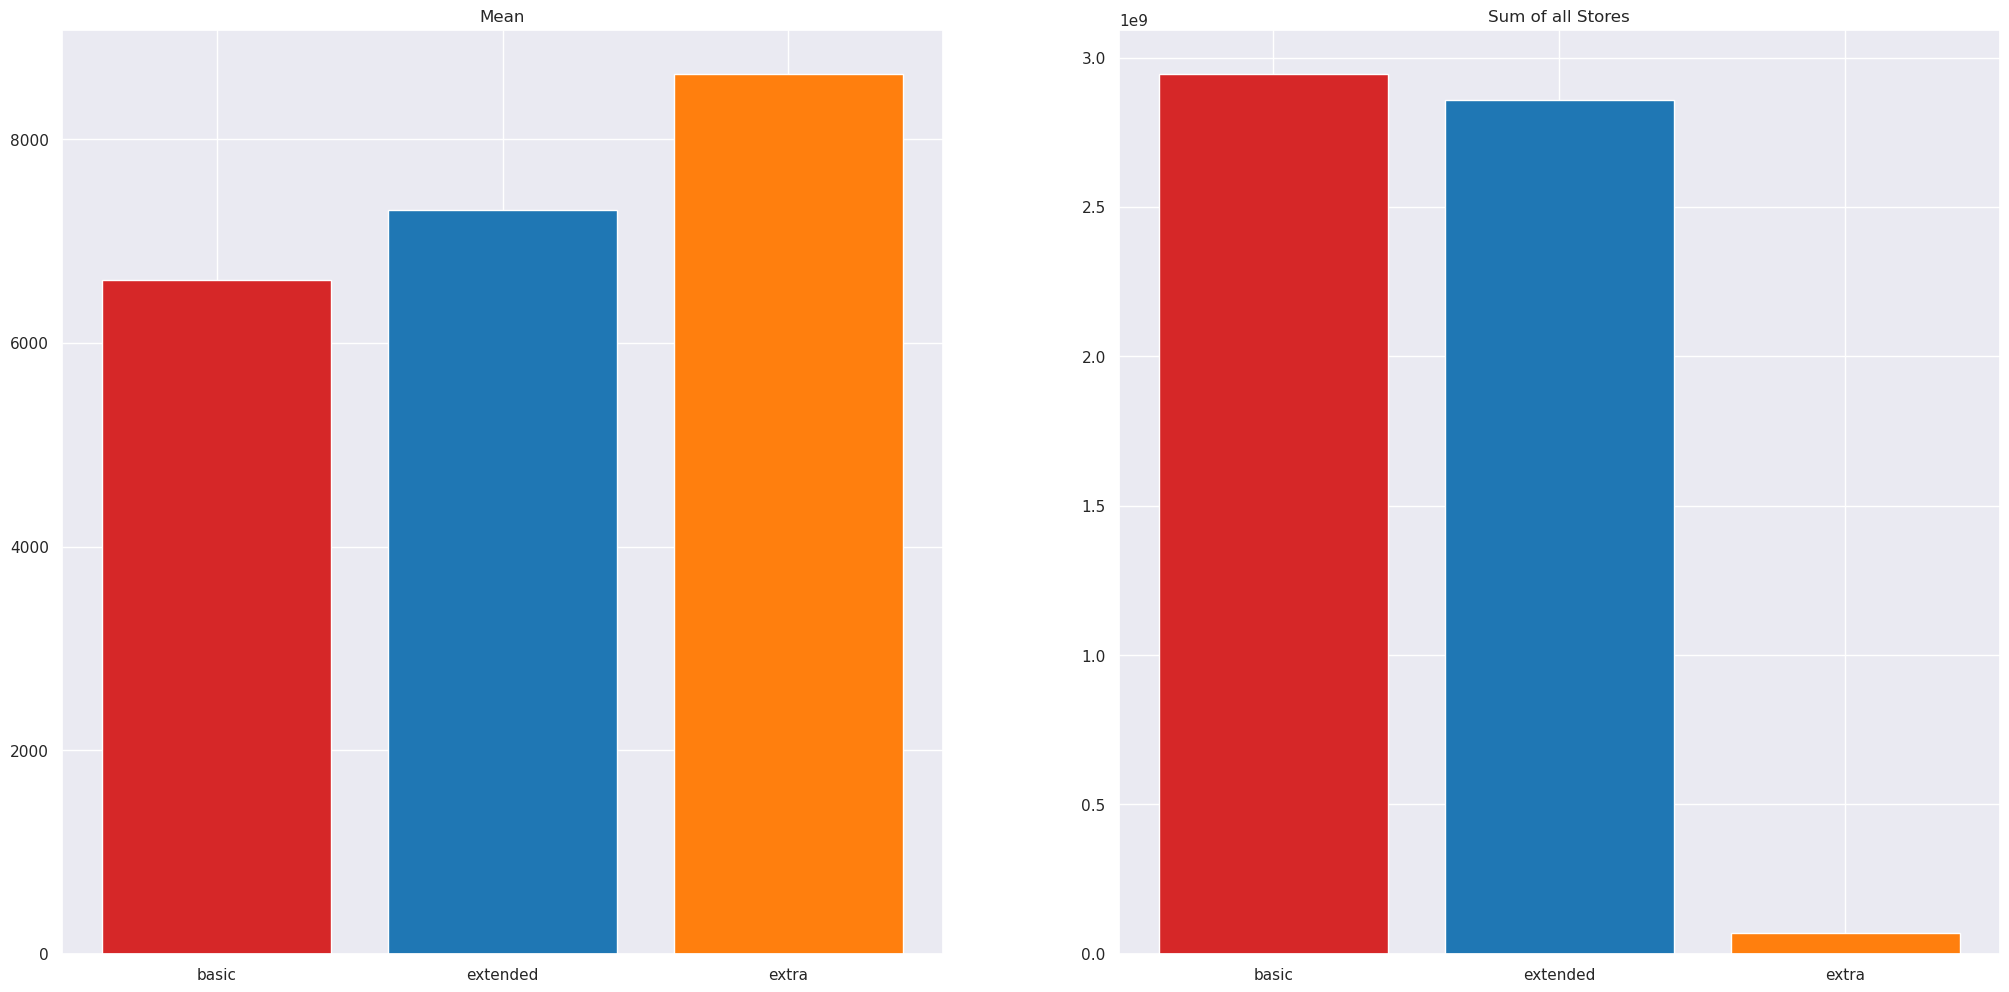

In [33]:
#1. Lojas com maior sortimentos deveriam vender mais.
a = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
b = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

# Average Sales per type of assortment
plt.subplot(1, 2, 1)
plt.bar(a['assortment'], a['sales'], color=bar_colors);
plt.title('Mean');

# Sum of sale in all stores
plt.subplot(1, 2, 2)
plt.bar(b['assortment'], b['sales'], color=bar_colors);
plt.title('Sum of all Stores');

### 2. Lojas com competidores mais próximos deveriam vender menos.
### FALSE
Lojas com competidores mais próximos vendem mais do que as com competidores longe.


<Axes: >

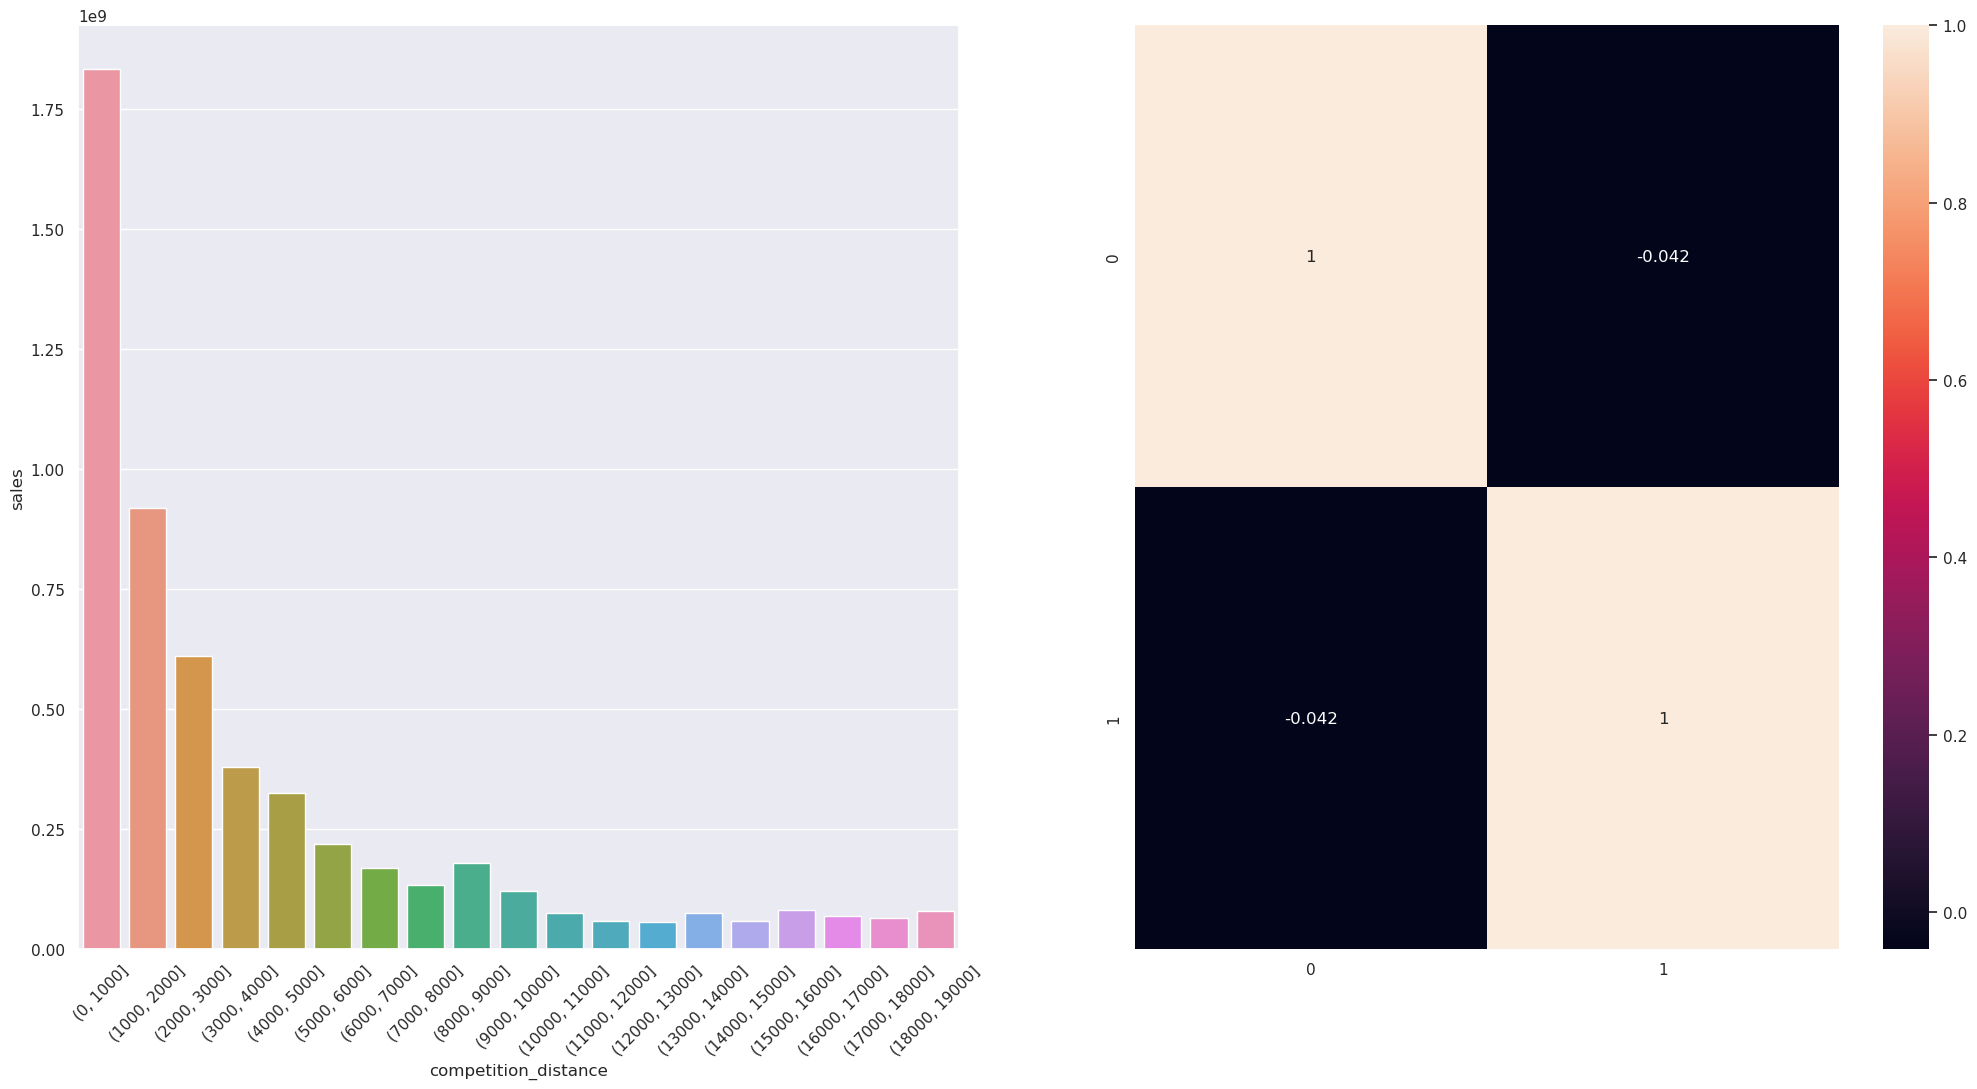

In [34]:
aux3 = df4.copy()
bins = list(np.arange(0, 20000, 1000))
aux3['competition_distance'] = pd.cut(aux3['competition_distance'], bins=bins)
aux4 = aux3[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Average Sales per type of assortment
plt.subplot(1,2,1)
sns.barplot(data=aux4, x='competition_distance', y='sales');
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.heatmap(np.corrcoef(df4['competition_distance'], df4['sales']), annot=True)


### 3. Lojas com competidores à mais tempo deveriam vendem mais.
### FALSE
Lojas com competidores a mais tempo vendem menos. Há uma tendencia de crecimento em datas próximas à abertuda de novos competidores.


<Axes: >

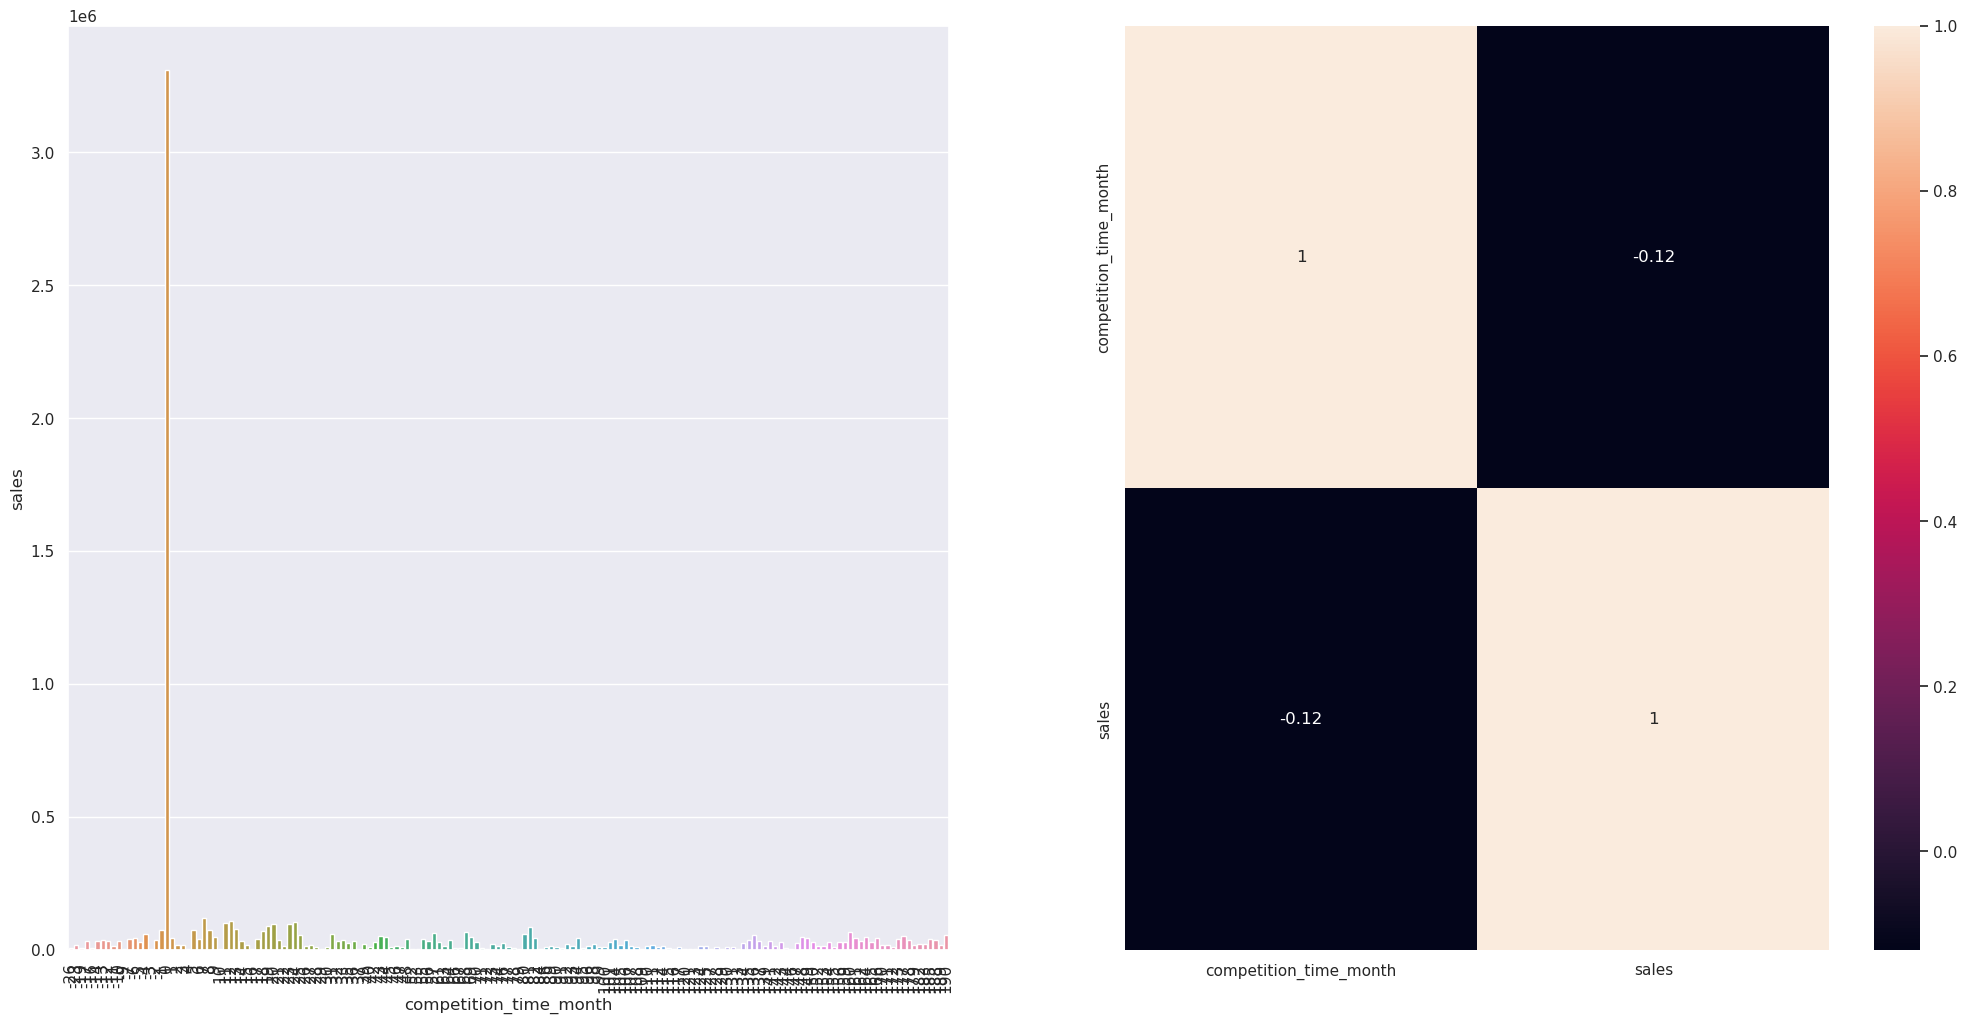

In [35]:
df7_aux2 = df4[(df4['competition_time_month'] < 120) & (df4['competition_time_month'] != 0)]
aux2 = aux1[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### FALSE


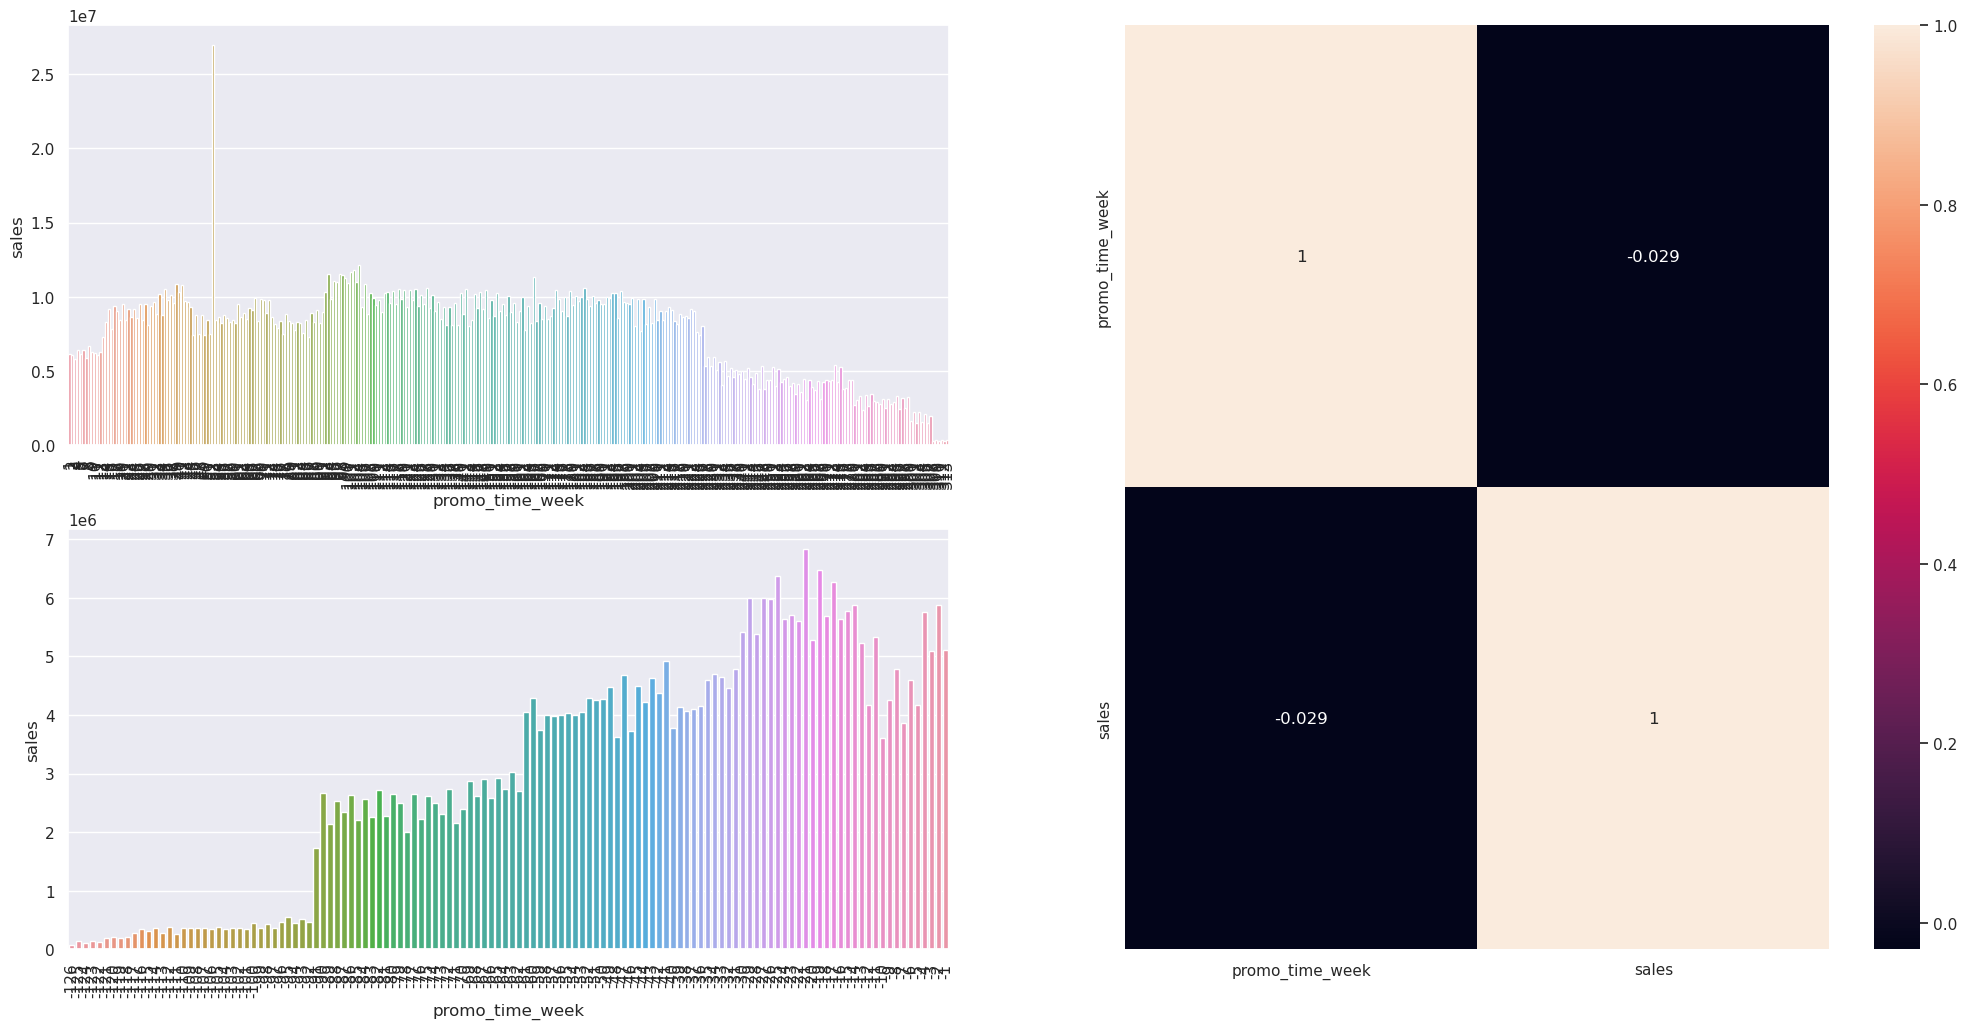

In [36]:
by_promo = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


by_promo1 = by_promo[by_promo['promo_time_week'] > 0]
by_promo2 = by_promo[by_promo['promo_time_week'] < 0]

plt.subplot(2,2,1)
sns.barplot(by_promo1, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(2,2,3)
sns.barplot(by_promo2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(by_promo.corr(method='pearson'), annot=True);

### 6. Lojas com mais promoções consecutivas deveriam vender mais.
### FALSE



In [37]:
by_promo = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

<Axes: >

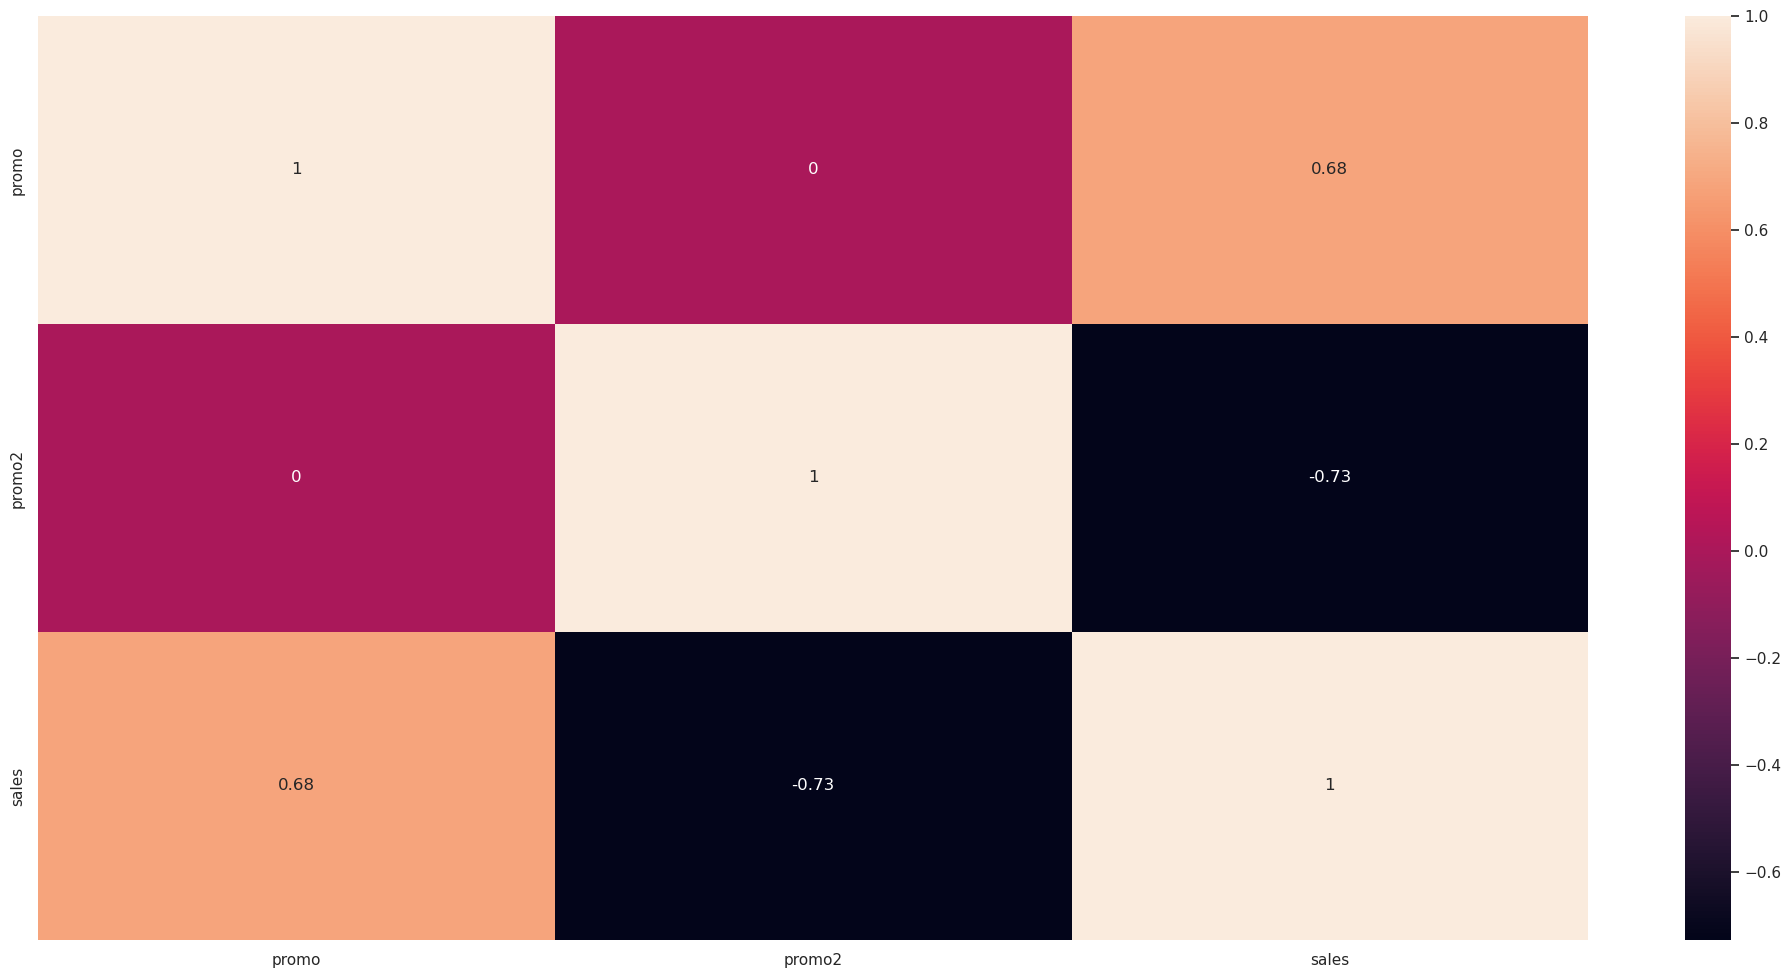

In [38]:
sns.heatmap(by_promo.corr(method='pearson'), annot=True)

### 7. Lojas abertas durante o feriado de Natal deveriam vender mais.
### FALSE
Lojas abertas em feriados publicos e estaduais são as que vendem mais.

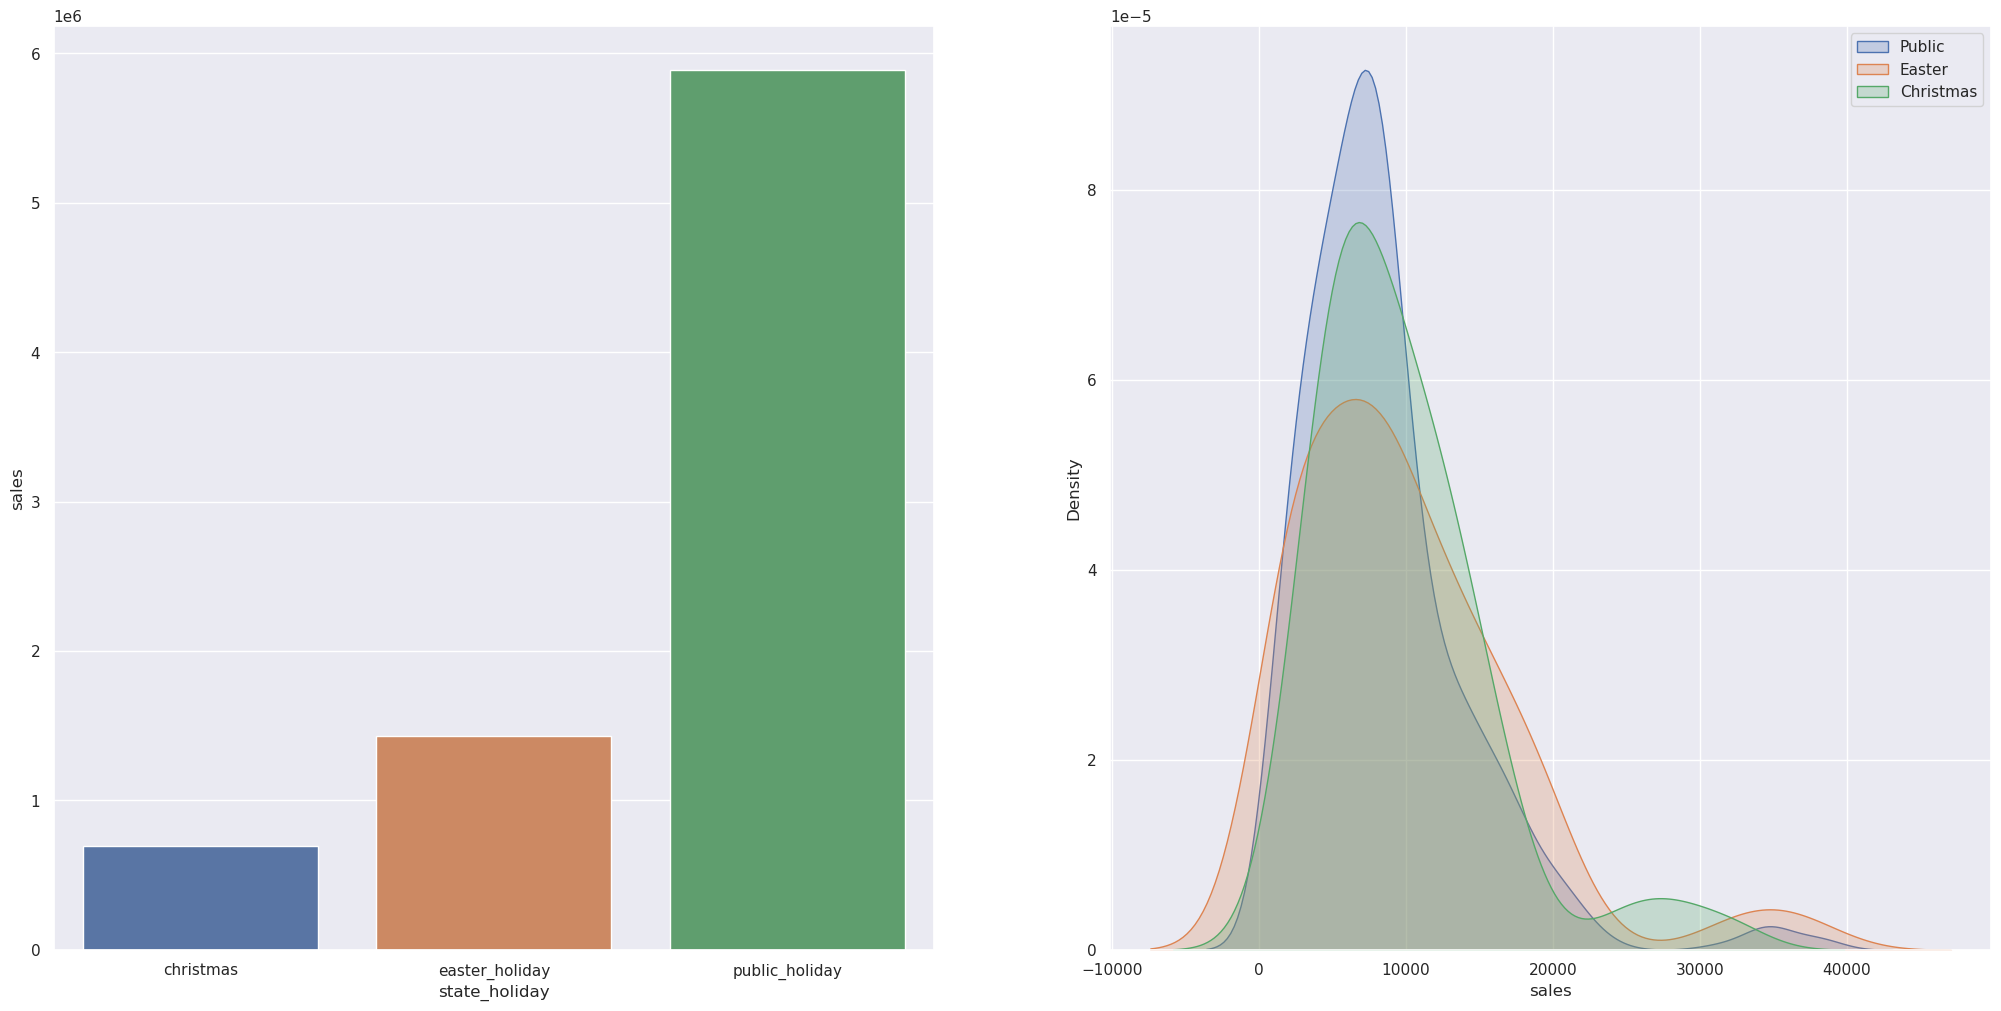

In [39]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
by_holiday = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(by_holiday, x='state_holiday', y='sales');

plt.subplot(1,2,2)
sns.kdeplot(aux1[aux1['state_holiday'] == 'public_holiday']['sales'], fill=True);
sns.kdeplot(aux1[aux1['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True, legend=False);
sns.kdeplot(aux1[aux1['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, legend=False);
plt.legend(labels=['Public', 'Easter', 'Christmas']);



### 8. Lojas deveriam vender mais ao longo dos anos.
### FALSE

<Axes: >

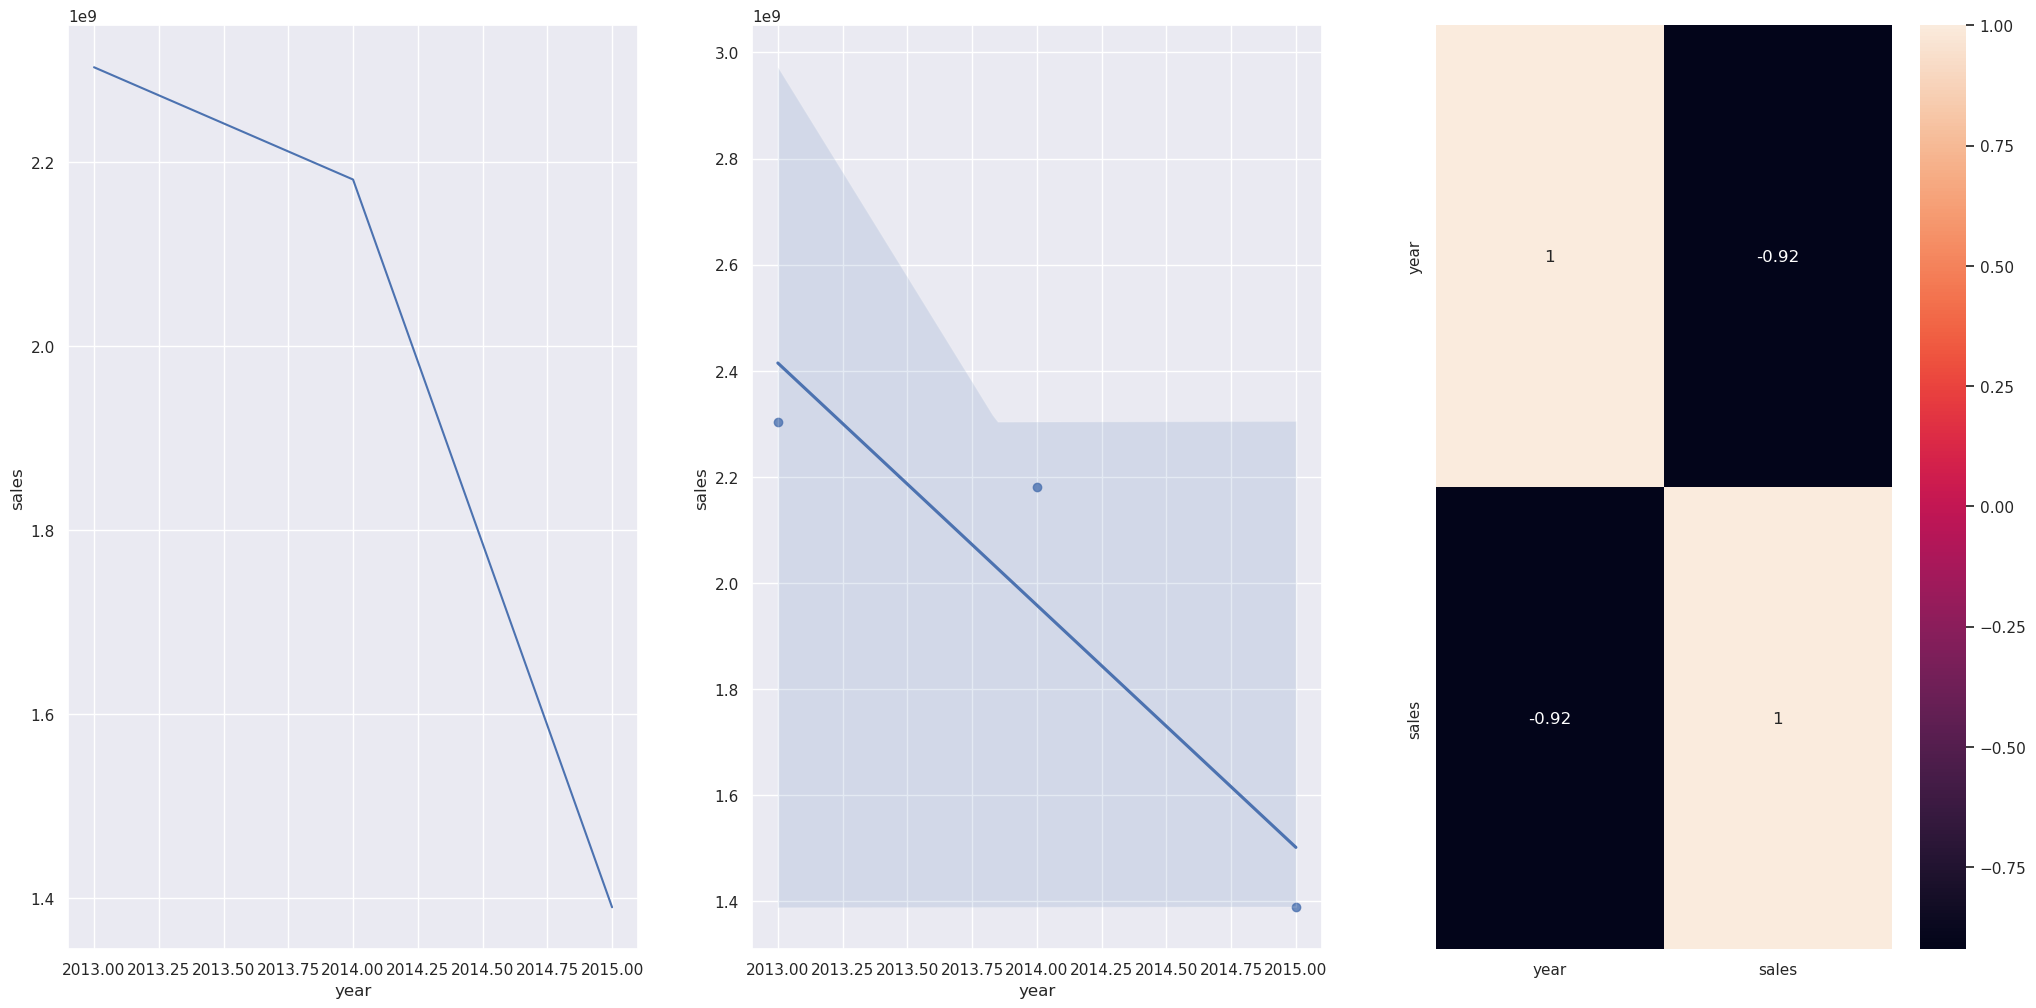

In [40]:
by_year = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.lineplot(by_year, x='year', y='sales');
plt.subplot(1,3,2)
sns.regplot(by_year, x='year', y='sales');
plt.subplot(1,3,3)
sns.heatmap(by_year.corr(method='pearson'), annot=True)

### 9. Lojas deveriam vender mais no segundo semestre do ano.
### FALSE

<Axes: >

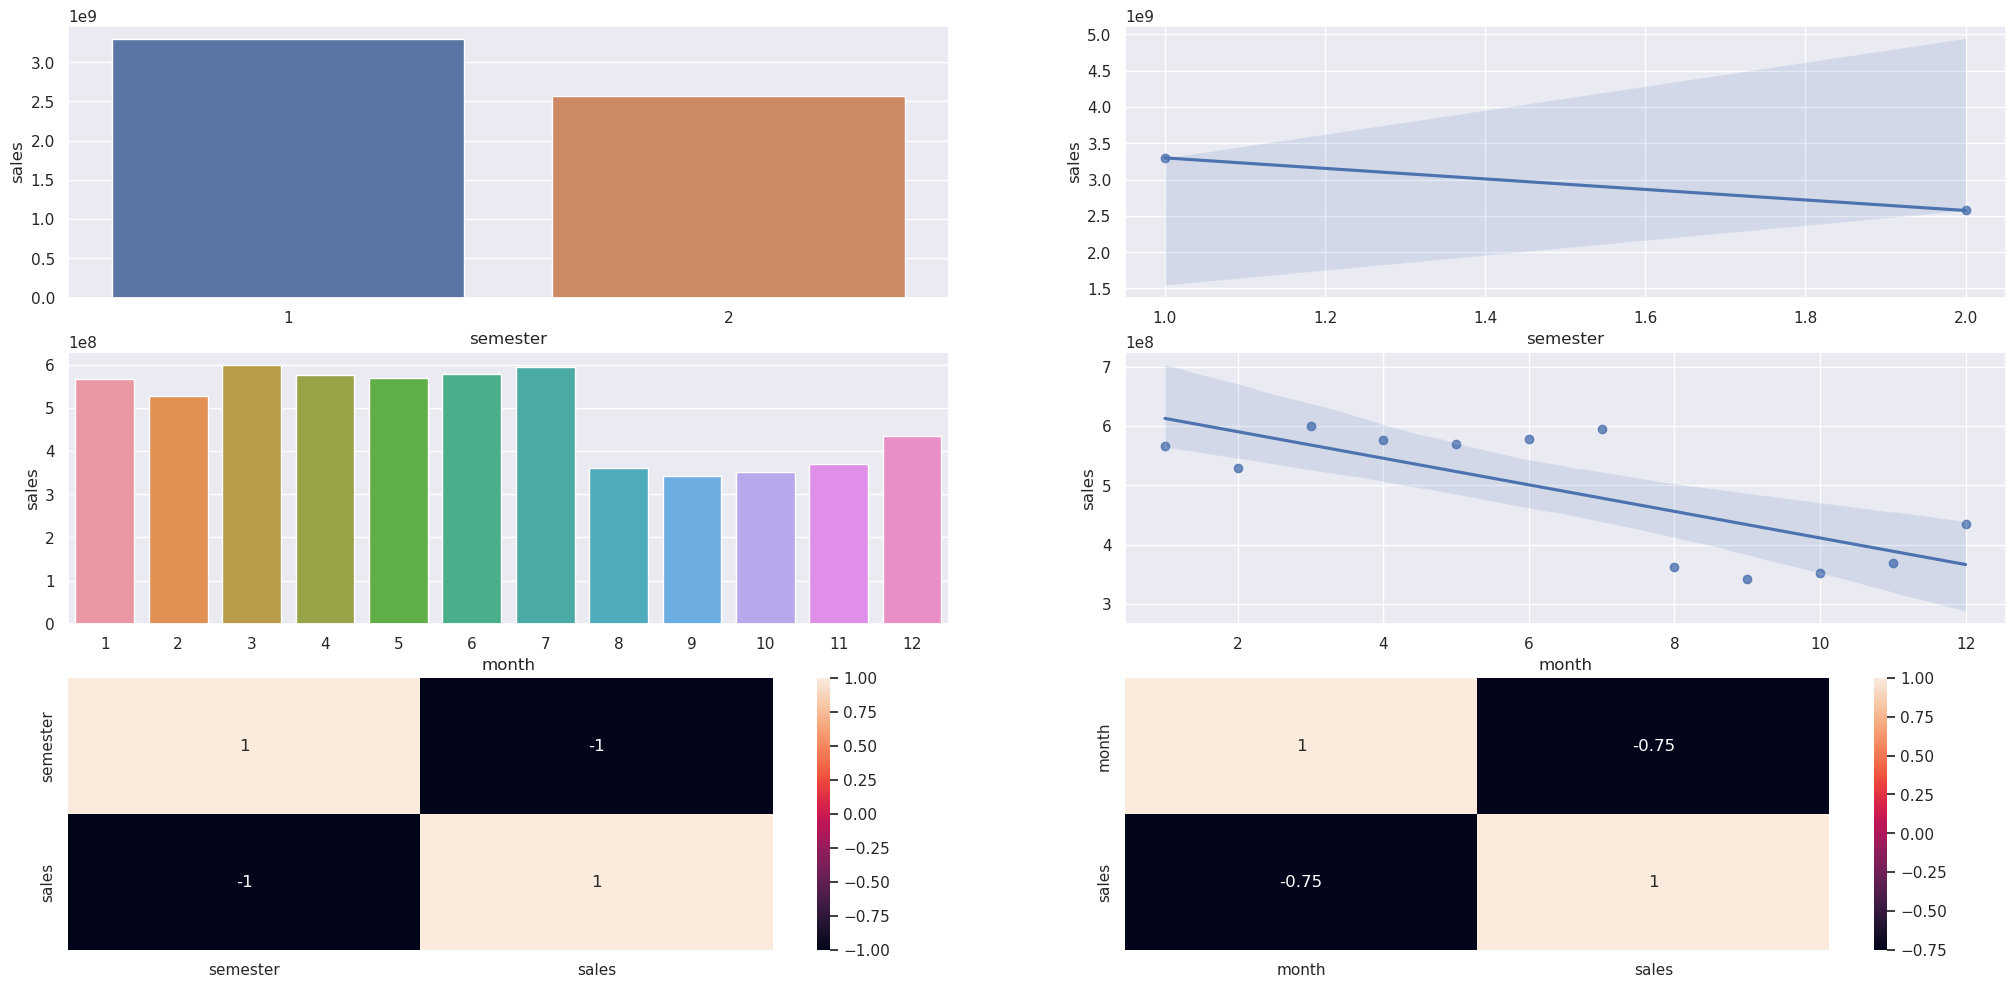

In [41]:
aux = df4.copy()
aux['semester'] = aux['week_of_year'].apply(lambda x: 2 if x >= 26 else 1)
by_semester = aux[['semester', 'sales']].groupby('semester').sum().reset_index()
by_month = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(3,2,1)
sns.barplot(by_semester, x='semester', y='sales');
plt.subplot(3,2,2)
sns.regplot(by_semester, x='semester', y='sales');
plt.subplot(3,2,3)
sns.barplot(by_month, x='month', y='sales')
plt.subplot(3,2,4)
sns.regplot(by_month, x='month', y='sales');
plt.subplot(3,2,5)
sns.heatmap(by_semester.corr(method='pearson'), annot=True)
plt.subplot(3,2,6)
sns.heatmap(by_month.corr(method='pearson'), annot=True)

### 10. Lojas deveriam vender mais depois do dia 10 de cada mês.
### TRUE

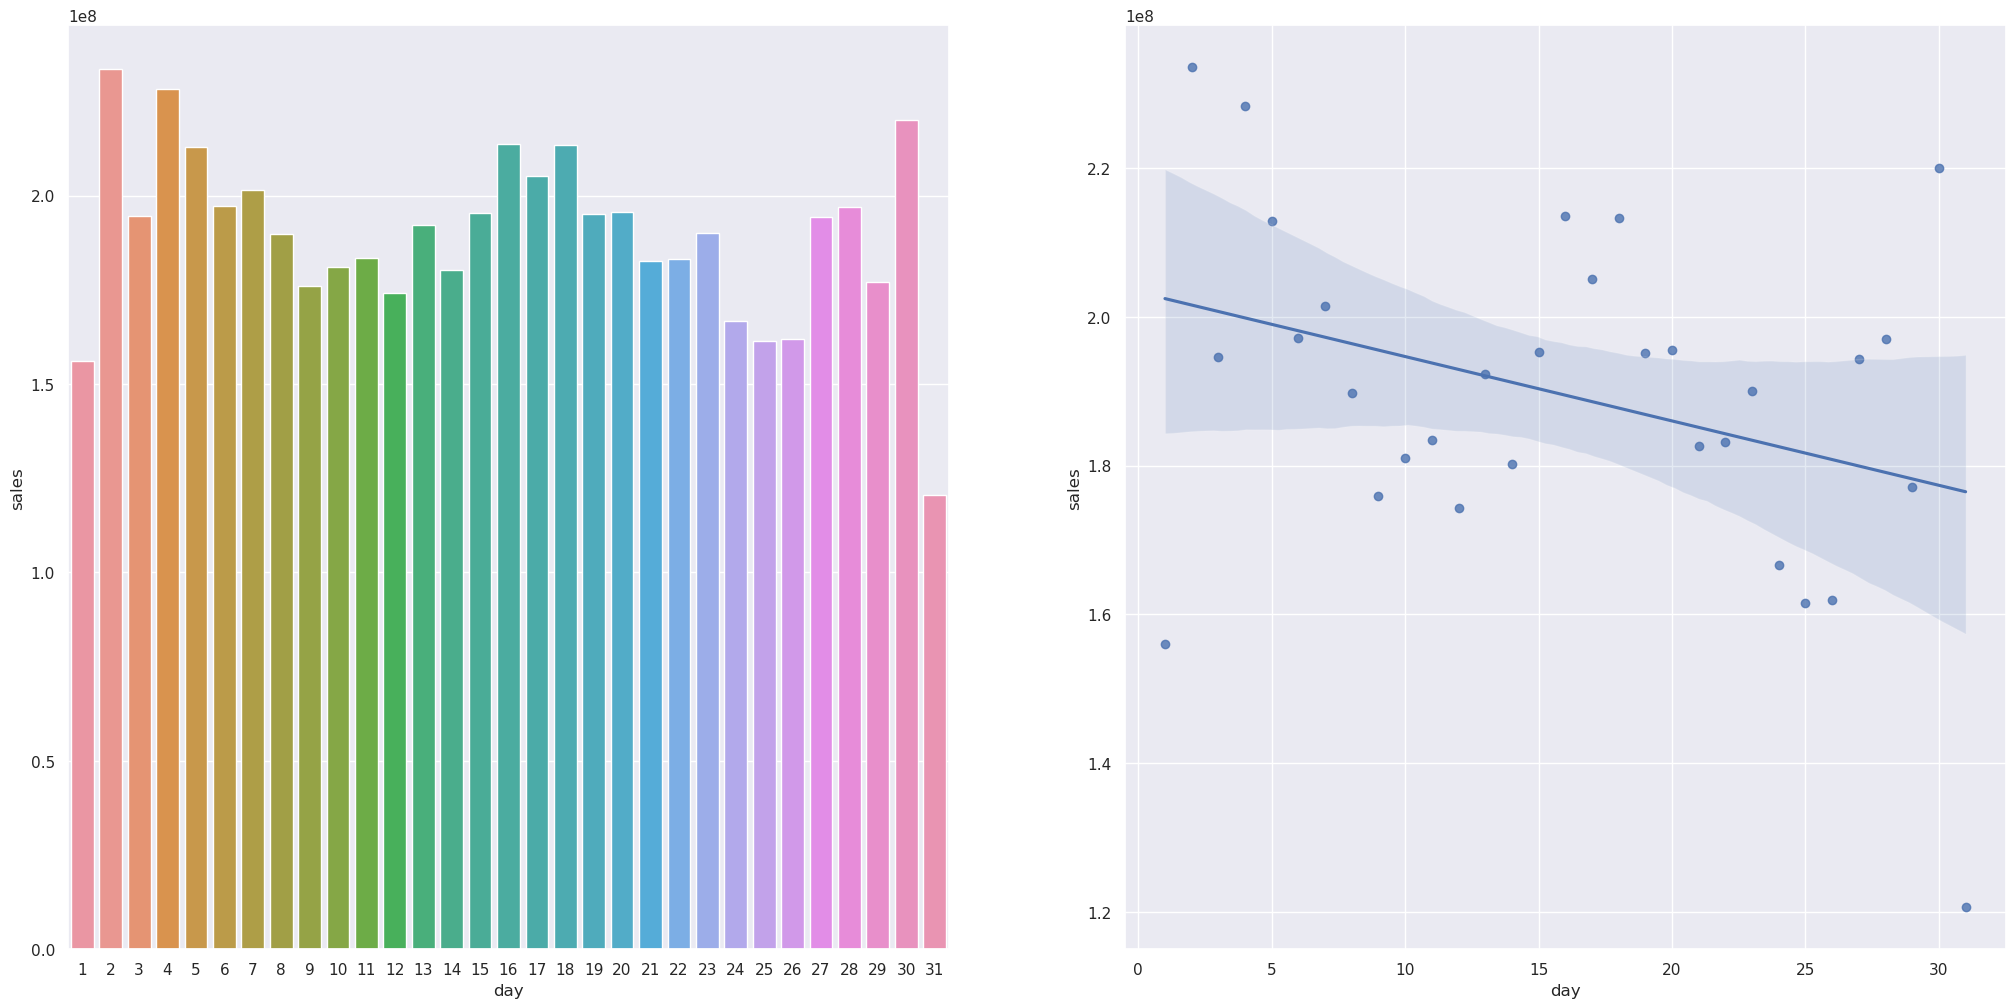

In [42]:
by_day = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(by_day, x='day', y='sales');
plt.subplot(1,2,2)
sns.regplot(by_day, x='day', y='sales');

### 11. Lojas deveriam vender menos aos finais de semana.
### TRUE

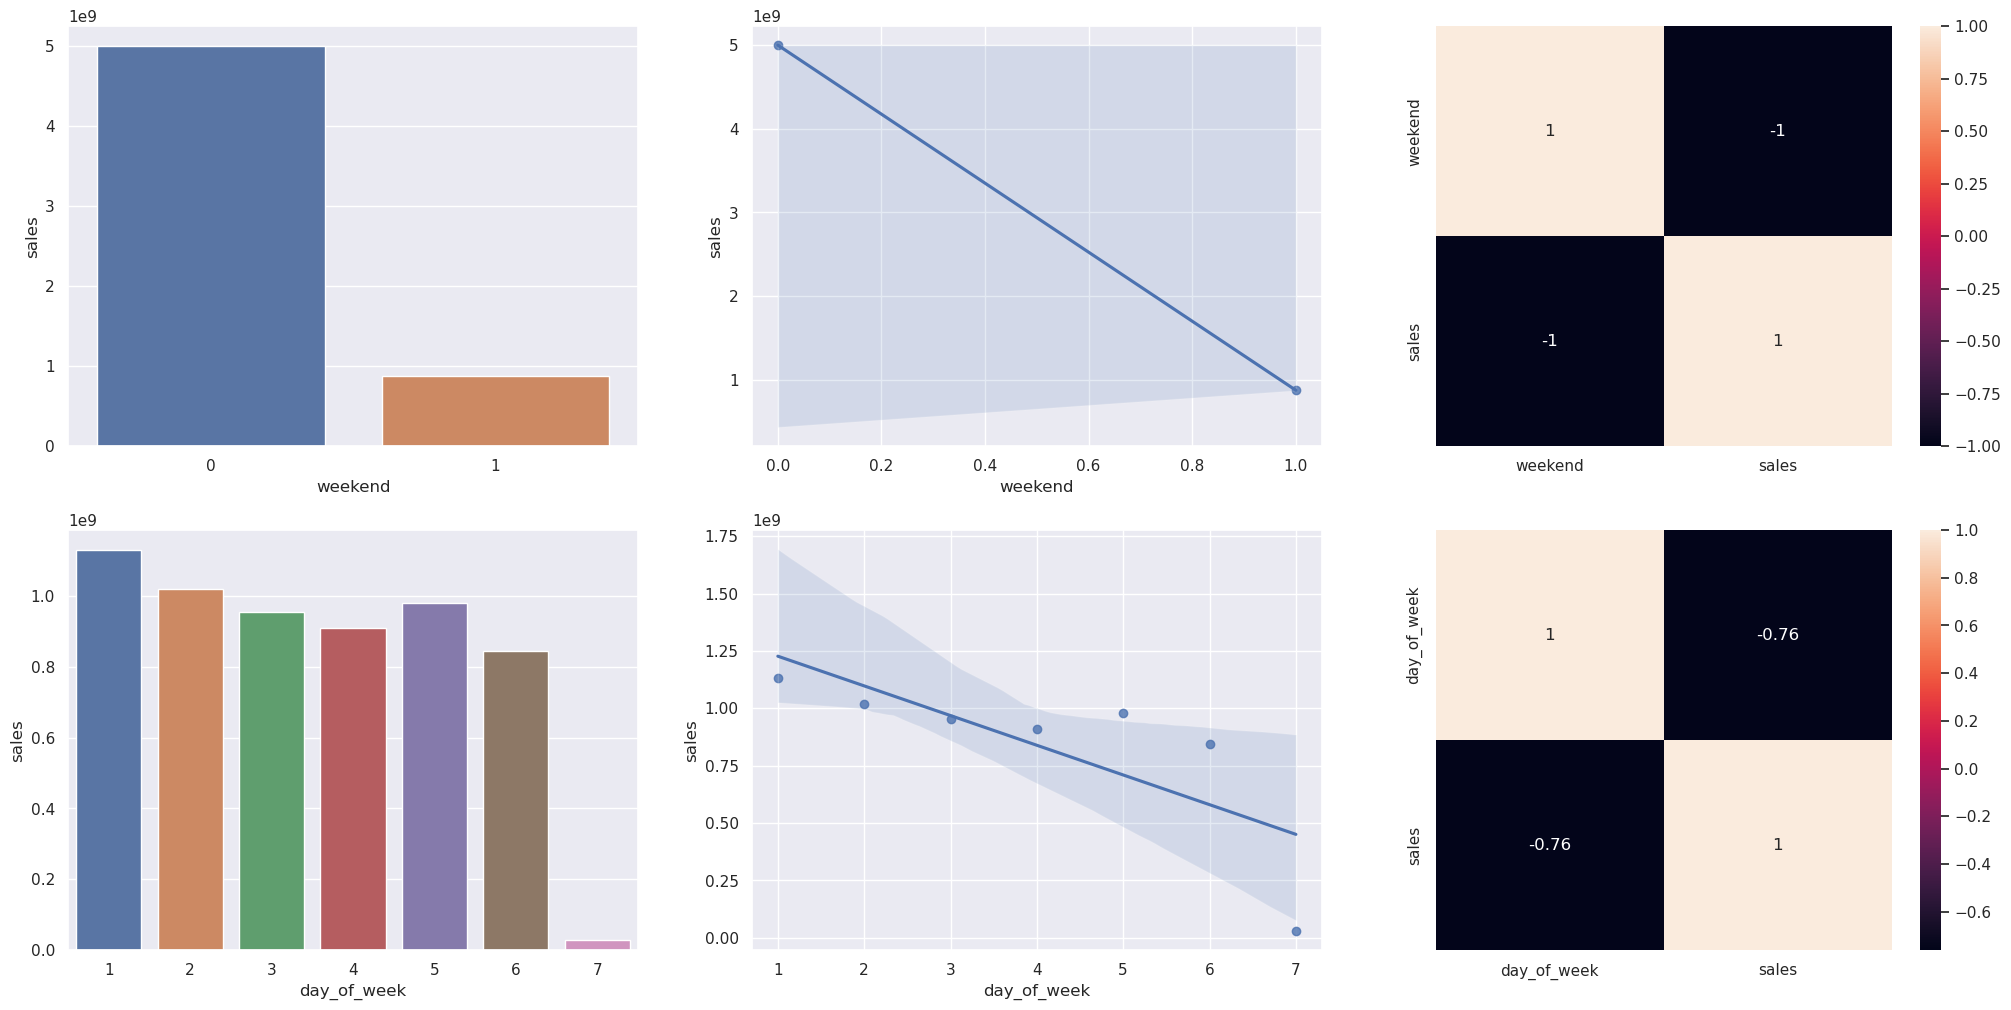

In [43]:
aux = df4.copy()
aux['weekend'] = aux['day_of_week'].apply(lambda x: 1 if (x == 6) | (x == 7) else 0)
by_weekend = aux[['weekend', 'sales']].groupby('weekend').sum().reset_index()
by_day = aux[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(by_weekend, x='weekend', y='sales');
plt.subplot(2,3,2)
sns.regplot(by_weekend, x='weekend', y='sales');
plt.subplot(2,3,3)
sns.heatmap(by_weekend.corr(method='pearson'), annot=True);

plt.subplot(2,3,4)
sns.barplot(by_day, x='day_of_week', y='sales');
plt.subplot(2,3,5)
sns.regplot(by_day, x='day_of_week', y='sales');
plt.subplot(2,3,6)
sns.heatmap(by_day.corr(method='pearson'), annot=True);

### 12. Lojas deveriam vender menos durante os feriados escolares.
### TRUE

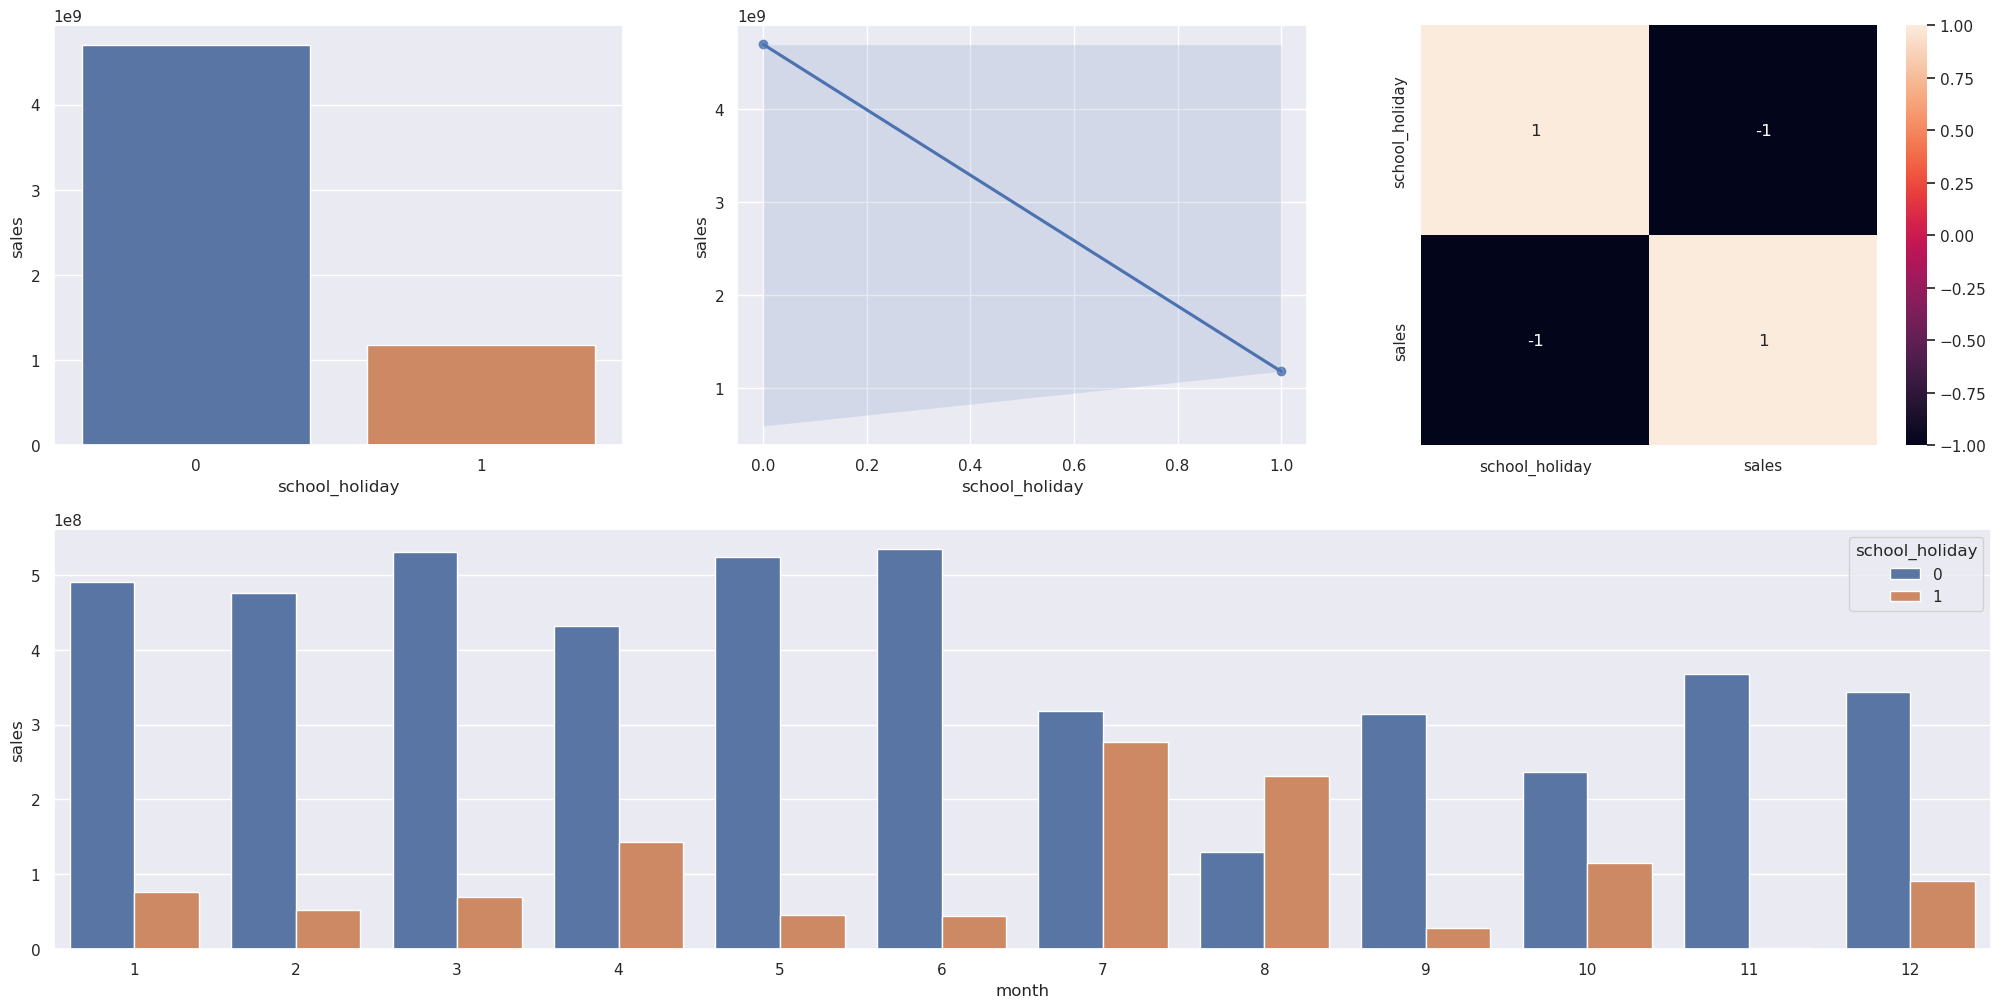

In [44]:
school_holiday = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
school_month = df4[['month', 'school_holiday', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(school_holiday, x='school_holiday', y='sales');
plt.subplot(2,3,2)
sns.regplot(school_holiday, x='school_holiday', y='sales');
plt.subplot(2,3,3)
sns.heatmap(school_holiday.corr(method='pearson'), annot=True);

plt.subplot(2,1,2)
sns.barplot(school_month, x='month', y='sales', hue='school_holiday');




### Resumo Hipoteses

In [45]:
tab = [['Hipotese', 'Conclusão', 'Relevancia'],
       ['H1', 'False', 'Baixa'],
       ['H2', 'False', 'Média'],
       ['H3', 'False', 'Média'],
       ['H4', 'False', 'Baixa'],
       ['H6', 'False', 'Baixa'],
       ['H7', 'False', 'Média'],
       ['H8', 'False', 'Alta'],
       ['H9', 'False', 'Alta'],
       ['H10', 'True', 'Alta'],
       ['H11', 'True', 'Alta'],
       ['H12', 'True', 'Baixa'],]
print( tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevancia
----------  -----------  ------------
H1          False        Baixa
H2          False        Média
H3          False        Média
H4          False        Baixa
H6          False        Baixa
H7          False        Média
H8          False        Alta
H9          False        Alta
H10         True         Alta
H11         True         Alta
H12         True         Baixa


### Multivariate Analysis

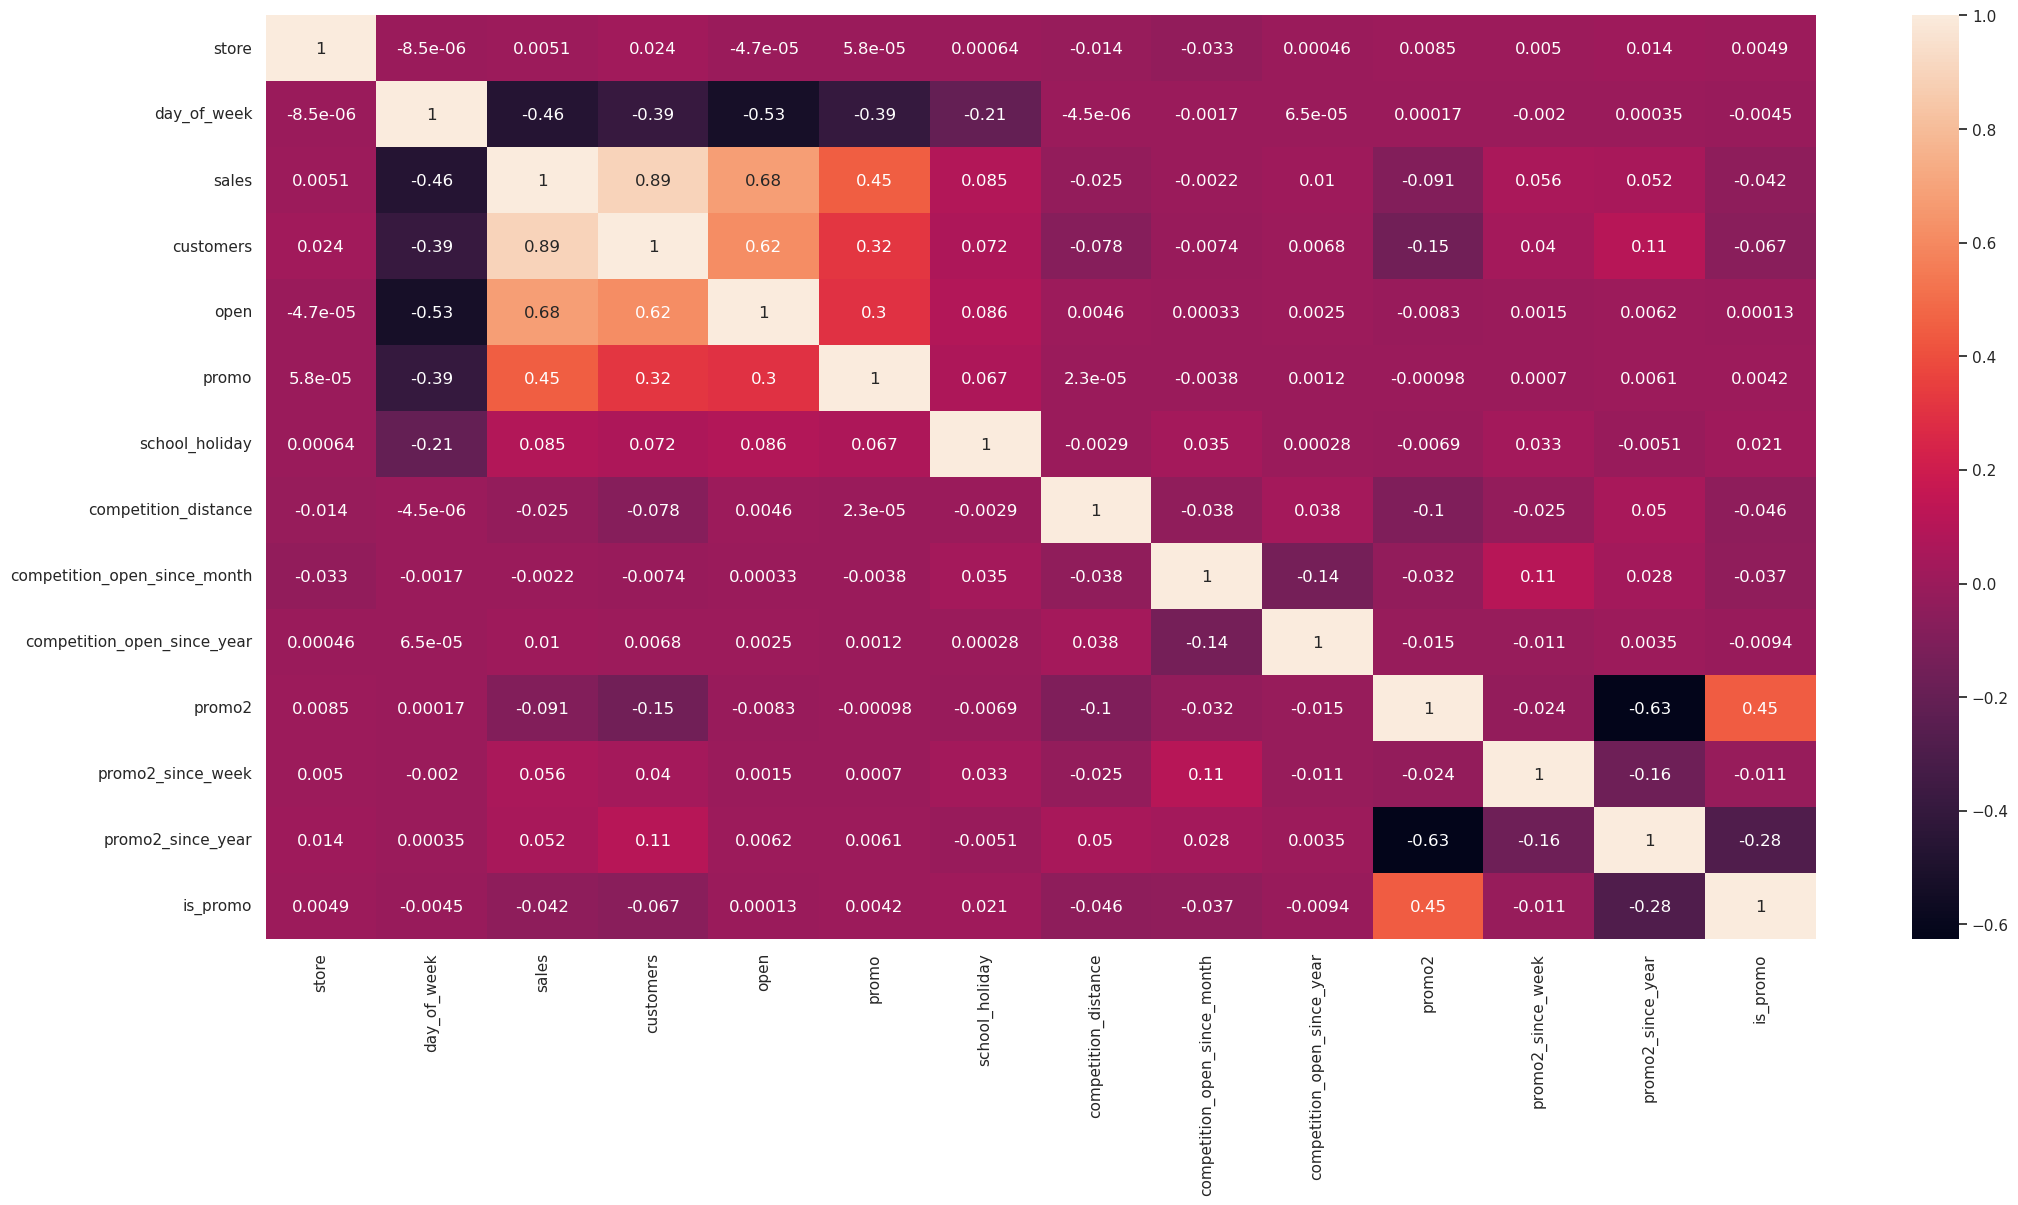

In [46]:
# Numeric correlation
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [47]:
# Categorical correlation
a = df4.loc[:, ['state_holiday', 'store_type', 'assortment']]

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / (min(kcorr - 1, rcorr - 1)))

<Axes: >

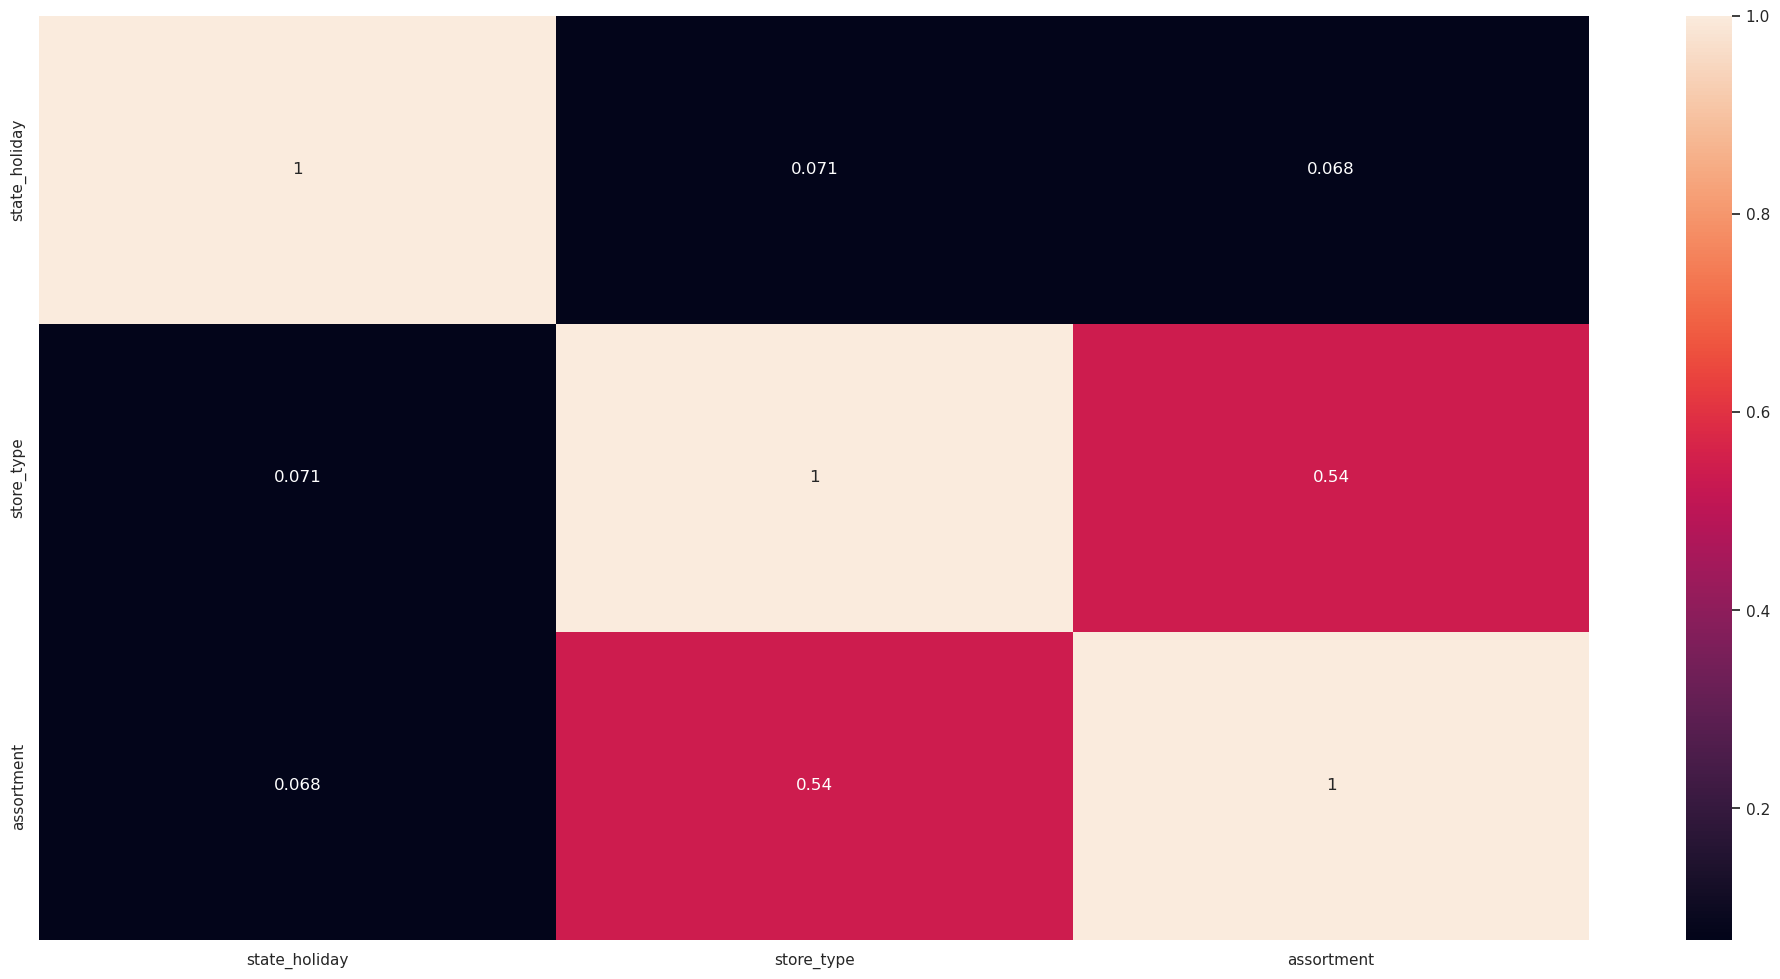

In [48]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

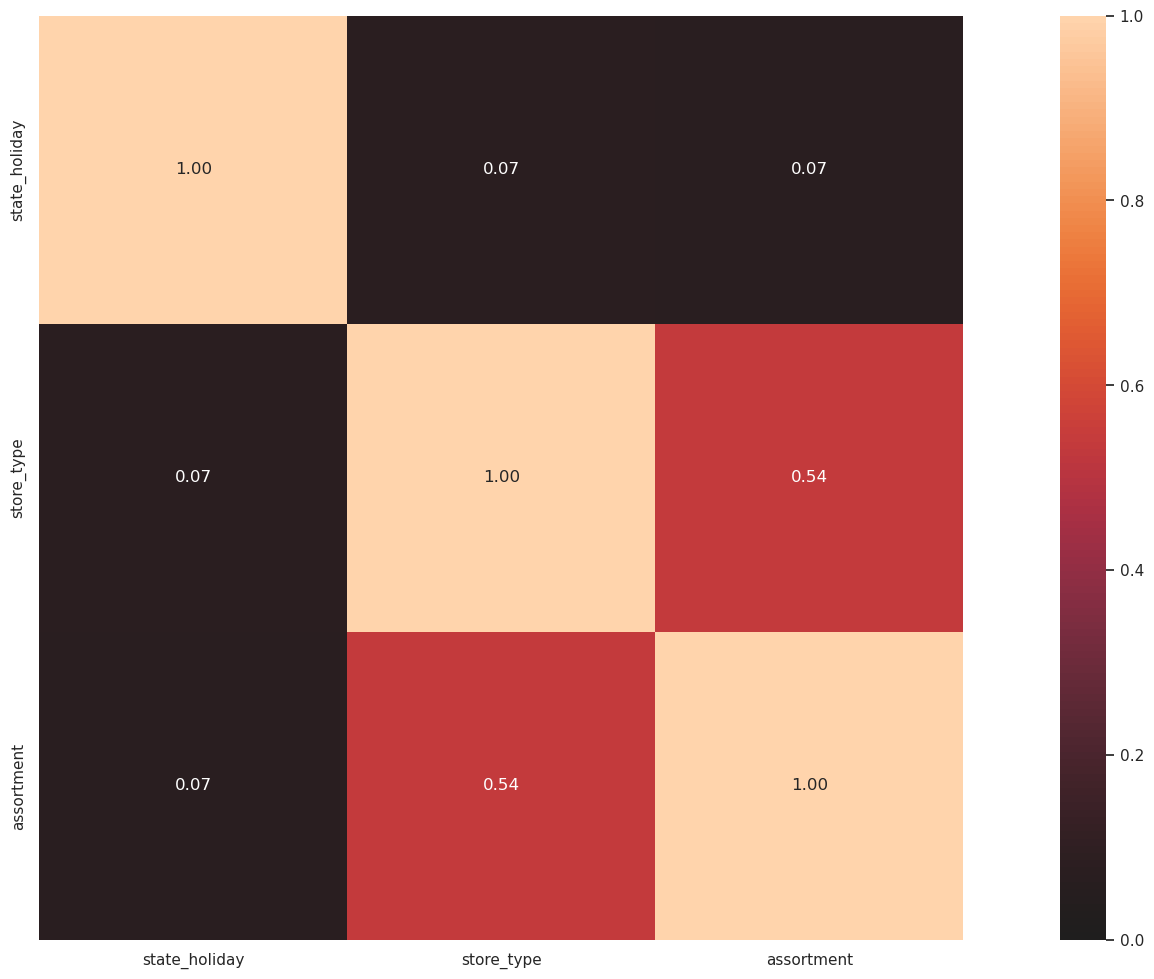

{'corr':                state_holiday  store_type  assortment
 state_holiday       1.000000    0.071040    0.067519
 store_type          0.071040    1.000000    0.538454
 assortment          0.067519    0.538454    1.000000,
 'ax': <Axes: >}

In [49]:
associations(a)

## 6.0 Data preparation

In [50]:
df5 = df3.copy()
df5['competition_time_month'] = df5['competition_time_month'].astype(np.int64)
df5['promo_time_week'] = df5['promo_time_week'].astype(np.int64)

### Rescaling

In [51]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [52]:
r_scaler = RobustScaler()
min_max = MinMaxScaler()

# competition distance
df5['competition_distance'] = r_scaler.fit_transform(df5[['competition_distance']].to_numpy())
pickle.dump(r_scaler, open('../repos/parameters/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = min_max.fit_transform(df5[['year']].to_numpy())
pickle.dump(min_max, open('../repos/parameters/year_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = r_scaler.fit_transform(df5[['competition_time_month']].to_numpy())
pickle.dump(min_max, open('../repos/parameters/competition_time_month_scaler.pkl', 'wb'))


# promo time week
df5['promo_time_week'] = min_max.fit_transform(df5[['promo_time_week']].to_numpy())
pickle.dump(min_max, open('../repos/parameters/promo_time_week.pkl', 'wb'))

### Encoding

In [53]:
# state holiday
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
label = LabelEncoder()
df5['store_type'] = label.fit_transform(df5['store_type'])
pickle.dump(label, open( '../repos/parameters/store_type_label_encoder.pkl', 'wb'))

# assortment
assortment_dic = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dic)

### Transformation

In [54]:
# Response variable response
df5['sales'] = np.log1p( df5['sales'])

In [55]:
# Nature transformation

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(2 * np.pi * x / 7 ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(2 * np.pi * x / 7 ))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(2 * np.pi * x / 12 ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(2 * np.pi * x / 12 ))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(2 * np.pi * x / 31 ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(2 * np.pi * x / 31 ))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(2 * np.pi * x / 52 ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(2 * np.pi * x / 52 ))

## 7.0 Feature Selection

In [56]:
df6 = df5.copy()

### Split train and test set

In [57]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 
             'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [58]:
# Train data set
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Train data set
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

### Boruta as Feature Selector

In [59]:
# Manual Feature Selection

cols_boruta_selected = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos'
 ]

# Columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_boruta_selected_full = cols_boruta_selected.copy()
cols_boruta_selected_full.extend(feat_to_add)

In [60]:
cols_boruta_selected_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

## 8.0 Machine Learning Modeling

In [61]:
# Define X_train and X_test with the boruta columns
x_train = X_train[cols_boruta_selected]
x_test = X_test[cols_boruta_selected]

# Time Series Data preparation
x_train_complete = X_train[ cols_boruta_selected_full ]

### Average Model

In [62]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='inner', on='store')
y_hat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Mode', np.expm1(y_test), np.expm1(y_hat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Mode,1354.800353,0.2064,1835.135542


### Linear Regression

In [63]:
# Linear Regression
linear = LinearRegression().fit(x_train, y_train)
y_hat_linear = linear.predict( x_test )

# Performance
linear_result = ml_error('LinearRegression', np.expm1(y_test), np.expm1(y_hat_linear))
linear_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,1867.654504,0.292836,2671.333847


### Lasso

In [64]:
# Linear Regression Regularized
lasso = Lasso(alpha=0.001).fit( x_train, y_train )
y_hat_lasso = lasso.predict( x_test )

# Prediction
lasso_result = ml_error('Lasso', np.expm1(y_test), np.expm1(y_hat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1870.005016,0.28825,2694.092897


### Random Forest

In [65]:
# Random Forest Regressor
forest = RandomForestRegressor(
    n_estimators=100, n_jobs=-1, random_state=42
).fit( x_train, y_train )
y_hat_forest = forest.predict( x_test )

# Results
forest_restult = ml_error('Random Forest', np.expm1(y_test), np.expm1(y_hat_forest))
forest_restult

,Model Name,MAE,MAPE,RMSE
0,Random Forest,682.107793,0.100582,1014.58007


### XGBoost

In [66]:
# XGBoost Regressor
xgb_regre = xgb.XGBRegressor().fit( x_train, y_train )
yhat_xgb = xgb_regre.predict( x_test )

# Results
xgb_restult = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_restult

,Model Name,MAE,MAPE,RMSE
0,XGBoost,869.174595,0.130294,1259.278419


### Compare the models perfomance

In [67]:
modeling_results = pd.concat([baseline_result, linear_result, 
                              lasso_result, forest_restult, xgb_restult])
modeling_results.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest,682.107793,0.100582,1014.580070
0,XGBoost,869.174595,0.130294,1259.278419
0,Average Mode,1354.800353,0.206400,1835.135542
0,LinearRegression,1867.654504,0.292836,2671.333847
0,Lasso,1870.005016,0.288250,2694.092897


### Time Series Cross Validation Manual

In [68]:
def cross_validation( x_traning, k_fold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, k_fold+1)):
        
        # start and end for validation
        val_start_date = x_train_complete['date'].max() - datetime.timedelta(days=k*6*7)
        val_end_date = x_train_complete['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        traning = x_train_complete[x_train_complete['date'] < val_start_date]
        validation = x_train_complete[(x_train_complete['date'] >= val_end_date) &
                                    (x_train_complete['date'] <= val_end_date)]

        # traning and validation dataset
        # traning
        xtraning = traning.drop(['date', 'sales'], axis=1)
        ytraning = traning['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraning, ytraning)

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

        if verbose:
                print('\nKflod Number: {}'.format(k))
                print('RMSE:', rmse_list)

        
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list),2).astype(str) + ' +\- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE': np.round(np.mean(mape_list),2).astype(str) + ' +\- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE': np.round(np.mean(rmse_list),2).astype(str) + ' +\- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [69]:
linear1 = LinearRegression()
lasso1 = Lasso(alpha=0.01)
forest1 = RandomForestRegressor(n_jobs=-1, max_depth=20, random_state=1)
xgb1 = xgb.XGBRegressor()

In [70]:
#linear_cross = cross_validation(x_train_complete, 5, 'LINEAR', linear1)

In [71]:
#lasso_cross = cross_validation(x_train, 5, 'LASSO', lasso1)

In [72]:
#forest_cross = cross_validation(x_train, 5, 'FOREST', forest1)

In [73]:
#xgb1_cross = cross_validation(x_train, 5, 'XGB', xgb1)

In [74]:
#manual_cross = pd.concat([linear_cross, lasso_cross, forest_cross, xgb1_cross])

### Time Series Cross Validarion Sklearn

In [75]:
lasso_cross_skt = cross_val(x_train_complete, 5, 'LASSO', lasso1)

In [76]:
forest_cross_skt = cross_val(x_train_complete, 5, 'FOREST', forest1)

KeyboardInterrupt: 

In [ ]:
xgb1_cross_skt = cross_val(x_train_complete, 5, 'XGB', xgb1)

In [ ]:
linear_cross_skt = cross_val(x_train_complete, 5, 'LINEAR', linear1)

In [ ]:
skl_cross = pd.concat([linear_cross_skt, lasso_cross_skt, forest_cross_skt, xgb1_cross_skt])

In [ ]:
#manual_cross

In [ ]:
skl_cross

,Model Name,MAE,MAPE,RMSE
0,LINEAR,2085.59 +\- 160.98,0.34 +\- 0.06,2904.28 +\- 151.21
0,LASSO,2007.75 +\- 86.36,0.3 +\- 0.01,2914.7 +\- 162.71
0,FOREST,983.85 +\- 69.7,0.14 +\- 0.01,1527.82 +\- 160.72
0,XGB,1091.36 +\- 107.38,0.16 +\- 0.01,1607.07 +\- 223.71


## 9.0 Fine Tunnig

### Random Search

In [ ]:
param = {
    'n_estimators': [150, 170, 250, 300, 350],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15] 
}
max_eval = 5

In [ ]:
final_resutl = pd.DataFrame()

for i in range(max_eval):
    # choose values randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators = hp['n_estimators'],
        eta = hp['eta'],
        max_depth = hp['max_depth'],
        colsample_bytree = hp['colsample_bytree'],
        min_child_weight = hp['min_child_weight']
    )
    # performance
    result = cross_val( x_train_complete, max_eval, 'XGBoost', model_xgb, verbose=True)
    final_resutl = pd.concat([final_resutl, result])

final_resutl

{'n_estimators': 150, 'eta': 0.01, 'max_depth': 5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 150, 'eta': 0.03, 'max_depth': 9, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 150, 'eta': 0.01, 'max_depth': 5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 170, 'eta': 0.03, 'max_depth': 5, 'colsample_bytree': 0.9, 'min_child_weight': 15}


,Model Name,MAE,MAPE,RMSE
0,XGBoost,5999.32 +\- 181.37,0.83 +\- 0.0,6722.09 +\- 206.82
0,XGBoost,1619.59 +\- 134.02,0.21 +\- 0.01,2393.73 +\- 224.36
0,XGBoost,6007.19 +\- 183.0,0.83 +\- 0.0,6741.53 +\- 207.64
0,XGBoost,3817.15 +\- 177.13,0.48 +\- 0.01,4756.59 +\- 208.84
0,XGBoost,1789.99 +\- 109.23,0.25 +\- 0.01,2631.38 +\- 197.56


In [ ]:
def train_model(params):
    n_estimators, eta, max_depth, colsample_bytree, min_child_weight = params

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        eta=eta,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight
    )
    model.fit(x_train, y_train)
    p = model.predict(x_test)

    return np.sqrt(mt.mean_absolute_error(np.expm1(y_test), np.expm1(p)))

space = [
    (150, 350),        # n_estimators
    (0.01, 0.03),      # eta
    (3, 9),            # max_depth
    (0.3, 0.9),        # colsample_bytree
    (3, 15)            # min_child_weight
]

resultado = dummy_minimize(train_model, space, random_state=1, n_calls=30)


In [ ]:
resultado.x

[328, 0.026926218333720345, 8, 0.7111317002380558, 14]

### Bayesian Search

### Final Model

In [ ]:
# Final Model
model_random_tunned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=3000,
    eta=0.03,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.711,
    min_child_weight=3).fit(x_train, y_train)

predict = model_random_tunned.predict( x_test )

In [ ]:
# performance
ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(predict))

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.533998,0.114908,1093.891592


In [ ]:
ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(predict))


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.533998,0.114908,1093.891592


In [ ]:
pickle.dump(model_random_tunned, open('../repos/model/model_rossmann.pkl', 'wb'))

## 10.0 Tradução e Interpretação do Erro

In [ ]:
df7 = X_test.loc[:, cols_boruta_selected_full]

#rescaling
df7['sales'] = np.expm1(df7['sales'])
df7['prediction'] = np.expm1(predict)

### Business Performance

In [ ]:
# sum of predictions
aux1 = df7[['store', 'prediction']].groupby('store').sum().reset_index()


# MAE
aux2 = df7[['store', 'sales', 'prediction']].groupby('store').apply(
    lambda x: mt.mean_absolute_error(x['sales'], x['prediction'])
).reset_index().rename(columns={0:'MAE'})


# MAPE
aux3 = df7[['store', 'sales', 'prediction']].groupby('store').apply(
    lambda x: (mt.mean_absolute_percentage_error(x['sales'], x['prediction'])) * 100
).reset_index().rename(columns={0:'MAPE'})


In [ ]:
# Merge
df7_aux = pd.merge(aux2, aux3, how='inner', on='store')
df7_aux2 = pd.merge(df7_aux, aux1, how='inner', on='store')

In [ ]:
# worst scenario
df7_aux2['worst_scenario'] = df7_aux2['prediction'] - df7_aux2['MAE']
df7_aux2['best_scenario'] = df7_aux2['prediction'] + df7_aux2['MAE']


In [ ]:
df8 = df7_aux2.copy()
df8['prediction'] = df8['prediction'].map( '$ {:,.2f}'.format)
df8['worst_scenario'] = df8['worst_scenario'].map( '$ {:,.2f}'.format)
df8['best_scenario'] = df8['best_scenario'].map( '$ {:,.2f}'.format)
df8['MAE'] = df8['MAE'].map( '$ {:,.2f}'.format)
df8['MAPE'] = df8['MAPE'].map( '{:,.2f} %'.format)

In [ ]:
df8.sample(10)

,store,MAE,MAPE,prediction,worst_scenario,best_scenario
798,799,$ 988.78,10.20 %,"$ 335,828.12","$ 334,839.35","$ 336,816.90"
743,744,$ 781.21,9.68 %,"$ 266,599.22","$ 265,818.01","$ 267,380.42"
41,42,"$ 1,005.61",9.78 %,"$ 378,927.47","$ 377,921.86","$ 379,933.08"
714,715,$ 597.43,14.17 %,"$ 237,816.31","$ 237,218.88","$ 238,413.74"
482,483,$ 815.66,28.28 %,"$ 186,300.94","$ 185,485.28","$ 187,116.59"
285,286,$ 807.11,30.63 %,"$ 165,312.16","$ 164,505.05","$ 166,119.27"
871,872,$ 645.51,8.97 %,"$ 282,357.12","$ 281,711.61","$ 283,002.64"
452,453,"$ 1,056.36",10.30 %,"$ 424,987.34","$ 423,930.98","$ 426,043.71"
67,68,"$ 1,026.67",12.30 %,"$ 279,199.12","$ 278,172.46","$ 280,225.79"
694,695,"$ 1,005.59",19.24 %,"$ 194,294.58","$ 193,288.99","$ 195,300.17"


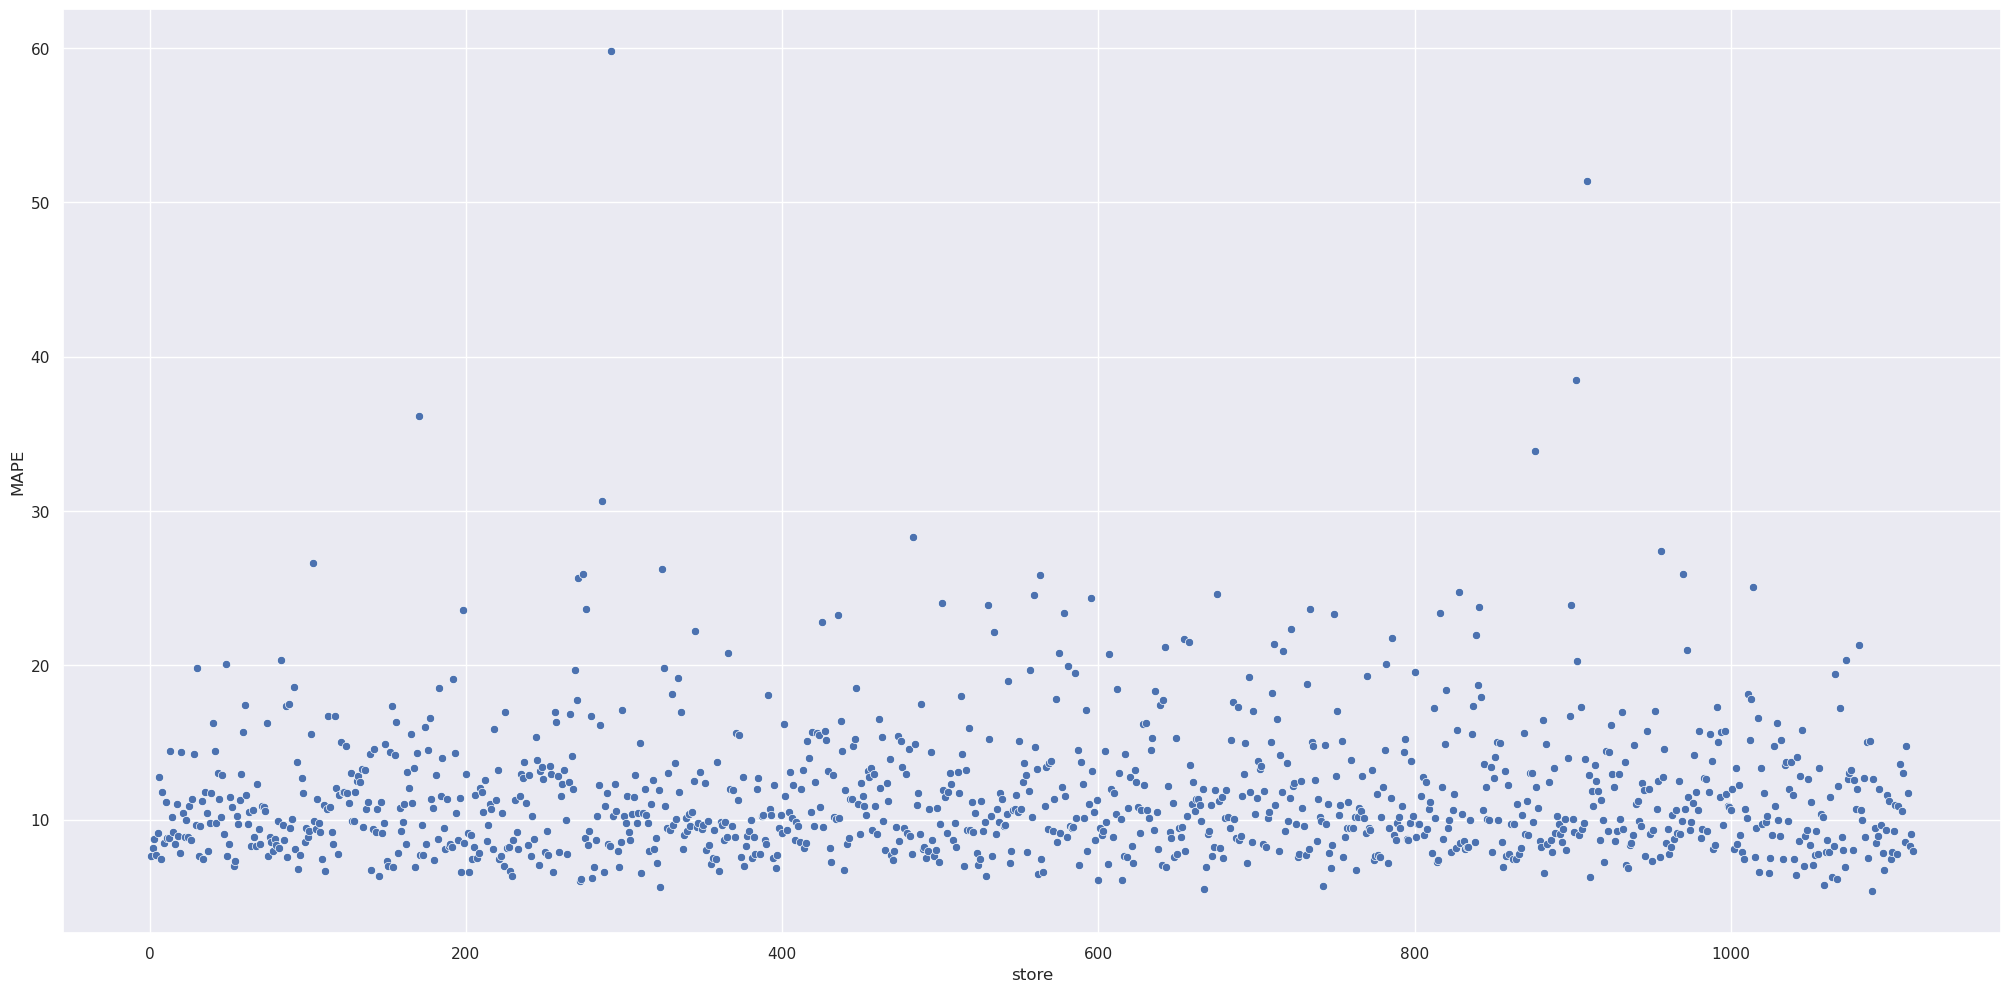

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df7_aux2);

### Total Performance

In [ ]:
df9 = df7_aux2.copy()

In [ ]:
df_aux = df9[['prediction', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0
).reset_index().rename(columns={'index': 'scenario', 0: 'values'})
df_aux['values'] = df_aux['values'].map('${:,.2f}'.format)
df_aux

,scenario,values
0,prediction,"$287,335,040.00"
1,worst_scenario,"$286,484,003.03"
2,best_scenario,"$288,186,103.57"


### Machine Learning Performance

In [ ]:
df7['error'] = df7['sales'] - df7['prediction']
df7['error_rate'] = df7['prediction'] / df7['sales']

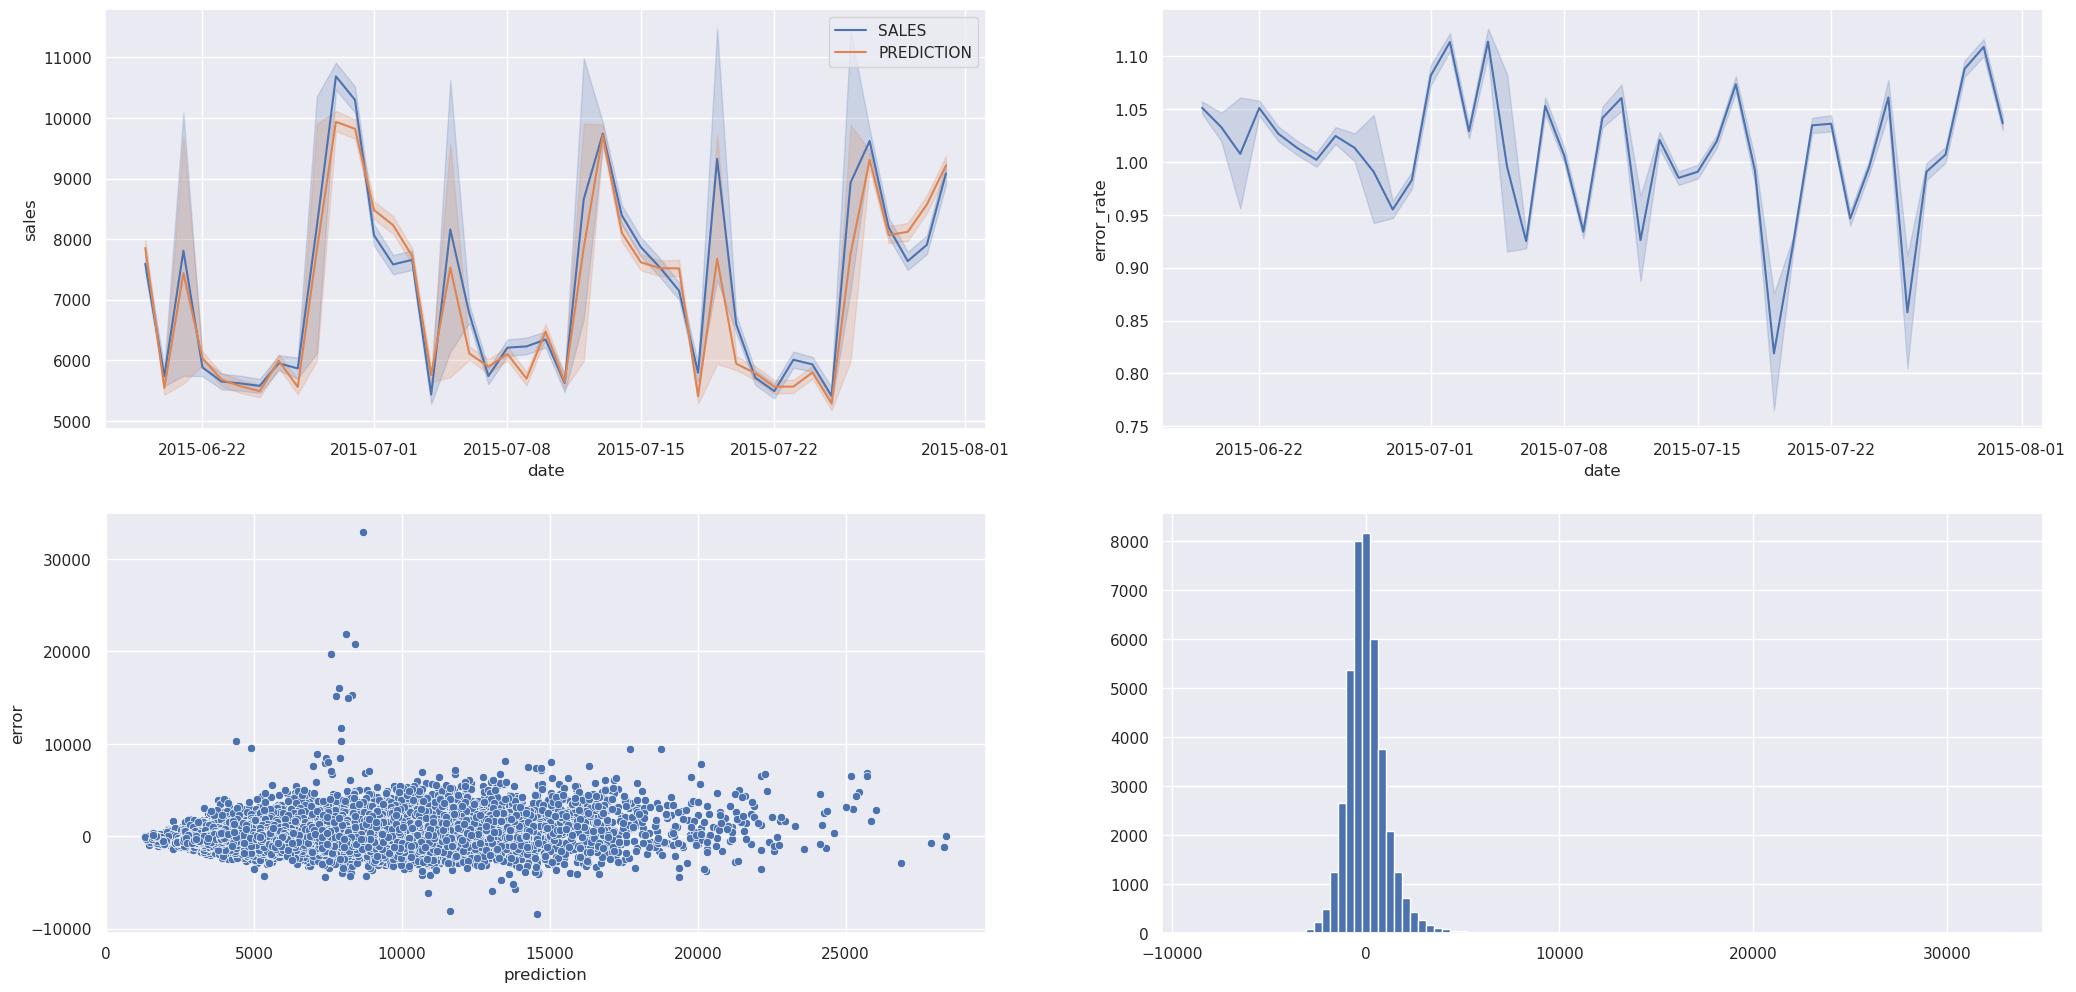

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df7, label='SALES');
sns.lineplot(x='date', y='prediction', data=df7, label='PREDICTION');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df7)

plt.subplot(2, 2, 3)
sns.scatterplot(x='prediction', y='error', data=df7);

plt.subplot(2, 2, 4)
plt.hist(df7['error'], bins=100);



## 11.0 Deploy the model

### Rosmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rosmann( object ):
    def __init__(self):
        self.home_path = '/home/natanmatos/Documents/repos/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameters/cometition_distance_scaler.pkl', 'rb'))
        self.min_max_scaler = pickle.load(open(self.home_path + 'parameters/min_max_scaler', 'rb'))
        self.label_encoder = pickle.load(open(self.home_path + 'parameters/label_encoder.pkl', 'rb'))
    
    def data_cleaning( self, df1):

        # Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        # Rename
        df1.columns = cols_new

        # Convert date type
        df1['date'] = pd.to_datetime( df1['date'] )

        # FILL OUT NAs
          #competition_distance       
        df1['competition_distance'] = df1['competition_distance'].apply(
            lambda x: 200000.0 if math.isnan( x ) else x
        )
        #competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(
                                                    lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1
                                                    )
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
                                                    lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1
                                                    )
        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply( 
                                            lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1
                                                    )
        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply( 
                                            lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1
                                                    )
        #promo2_since_year 
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # Change astype
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

        # promo_interval
        df1['promo_interval'].fillna(0, inplace=True)
        map_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['month_map'] = df1['date'].dt.month.map( map_month )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        return df1
    
    def feature_engineering(self, df2):

        ## 
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        ## Feature Filter
        
        # Filter columns
        drop_cols = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(drop_cols, axis=1)

        return df2

    def data_preparation(self, df5):
        df5['competition_time_month'] = df5['competition_time_month'].astype(np.int64)
        df5['promo_time_week'] = df5['promo_time_week'].astype(np.int64)

        ## Rescaling
        # competition distance
        df5['competition_distance'] = self.robust_scaler.fit_transform(df5[['competition_distance']].to_numpy())
        # year
        df5['year'] = self.min_max_scaler.fit_transform(df5[['year']].to_numpy())
        # competition time month
        df5['competition_time_month'] = self.robust_scaler.fit_transform(df5[['competition_time_month']].to_numpy())
        # promo time week
        df5['promo_time_week'] = self.min_max_scaler.fit_transform(df5[['promo_time_week']].to_numpy())

        ## Enconding
        # state holiday
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type      
        df5['store_type'] = self.label_encoder.fit_transform(df5['store_type'])

        # assortment
        assortment_dic = {'basic': 1,
                        'extra': 2,
                        'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dic)

        ## Data Nature Transformation

               
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(2 * np.pi * x / 7 ))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(2 * np.pi * x / 7 ))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(2 * np.pi * x / 12 ))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(2 * np.pi * x / 12 ))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(2 * np.pi * x / 31 ))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(2 * np.pi * x / 31 ))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(2 * np.pi * x / 52 ))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(2 * np.pi * x / 52 ))

        ## Feature Selection
        # Manual Feature Selection

        cols_selected = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos'
        ]

        return df5[ cols_selected ]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records',date_format='iso')

### API Handler

In [ ]:
import pickle
import pandas          as pd
import requests

from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Load the model
model = pickle.load(open('/home/natanmatos/Documents/repos/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())

        # instantiate Rosmann Class
        pipeline = Rossmann()

        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature Engineering
        df2 = pipeline.feature_enginnering( df1 )

        # Data Preparation
        df3 = pipeline.data_preparation( df2 )

        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0') 


ModuleNotFoundError: No module named 'rossmann'

### API Tester

In [4]:
# loading test data
df10 = pd.read_csv('/home/natanmatos/Documents/repos/dataset/test.csv')

In [5]:
 # merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )



In [6]:
# convert DataFrame into json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [8]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-api-t2qp.onrender.com'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200
